## Apis mellifera snRNAseq Analysis

antman environment

In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import re
from pygenomeviz import GenomeViz
import scipy.stats as stats
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")
import math
sys.path.append('../')
from transcriptomics import *
from plotting import * 
white_plotting()

/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/Users/giacomo.glotzer/miniconda3/envs/antman/lib/python3.12/s

Initializing transcriptomics package
Initializing plotting package


In [2]:
sc.set_figure_params(dpi=100, color_map="viridis_r")
sc.settings.verbosity = 0 
sc.logging.print_header()

scanpy==1.10.1 anndata==0.11.4 umap==0.5.5 numpy==1.26.4 scipy==1.13.0 pandas==2.2.1 scikit-learn==1.4.2 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
# set pd max columns to 100 and max rows to 10 
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

## Genome

In [4]:
# Load genome
genome_fasta_path = '../raw-data/Amell/genome/GCF_003254395.2_Amel_HAv3.1_genomic.fna'
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_fasta_path, "fasta"))

In [5]:
# Get number of scaffolds 
scaffolds = list(genome_seq.keys())
print(f'Number of scaffolds: {len(scaffolds)}')

# Make a dictionary of scaffold lengths
scaffold_lengths = {scaffold:len(genome_seq[scaffold].seq) for scaffold in scaffolds}
scaffold_lengths = pd.DataFrame.from_dict(scaffold_lengths, orient='index', columns=['length'])
scaffold_lengths = scaffold_lengths.sort_values(by='length', ascending=False)
scaffold_lengths

Number of scaffolds: 177


,length
NC_037638.1,27754200
NC_037643.1,17789102
NC_037648.1,16352600
NC_037639.1,16089512
NC_037644.1,14198698
...,...
NW_020555856.1,3152
NW_020555857.1,3072
NW_020555858.1,2987
NW_020555946.1,2376


## Custom OR Transcriptome
- Gene uses `gene_id` and transcript uses `transcript_id`
- Only run this once

In [6]:
genome_fasta_path = '../raw-data/Amell/genome/GCF_003254395.2_Amel_HAv3.1_genomic.fna'
transcriptome_path = "../raw-data/Amell/transcriptome/Amel_HAv31_ncbi.gtf"
object_name = "../raw-data/Amell/transcriptome/amellifera_transcriptome"
update_transcriptome_object(genome_fasta_path, transcriptome_path, object_name, other_fields=['gene_biotype', 'transcript_biotype']) 

Found 12398 unique genes.


100%|██████████| 12398/12398 [00:26<00:00, 461.66it/s]


Transcriptome(genes=12398)
Transcriptome object has been updated and saved to ../raw-data/Amell/transcriptome/amellifera_transcriptome.pkl


In [7]:
object_name = "../raw-data/Amell/transcriptome/amellifera_transcriptome"
tr = load_transcriptome_object(object_name)

In [8]:
check_exons_contain_all_features(tr)

In [9]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcript_biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(1858, 12356)

## OR DB
- Blastn revealed that "Or2" is Apis Mellifera ortholog of Orco 

In [10]:
all_genes = list(tr.genes.keys())

In [11]:
ta_db_path = '../raw-data/Amell/ORs/or_groups_from_Zhang_supplement.xlsx'
ta_db = pd.read_excel(ta_db_path)
ta_db.head(5)

,OR gene names in NCBI,"Robertson, H. M., & Wanner, K. W. (2006)",Pident,OR gene names in this study,Group,Start,End,Width,Strand,Transcript ID,Adjusted
0,LOC100578400,NA,0.0,LOC100578400,Group9,9370774,9373667,2894,-,XM_026442780.1,NaN
1,LOC102653858,NA,0.0,LOC102653858,Group13,1003533,1013279,9747,+,GSAman00023,NaN
2,LOC102653897,NA,0.0,LOC102653897,Group13,919759,924795,5037,+,XM_026444719.1,NaN
3,LOC102653979,NA,0.0,LOC102653979,GroupUN24,198771,200342,1572,-,XM_026445955.1,1.0
4,LOC102656567-b,NA,0.0,LOC102656567-b,Group9,9749864,9751731,1868,-,GSAman00027,NaN


In [12]:
# Remove trailing spaces 
ta_db = ta_db.applymap(lambda x: x.strip() if isinstance(x, str) else x)
ta_db.columns = [col.strip() for col in ta_db.columns]

In [13]:
ta_db = ta_db.rename(columns={"OR gene names in NCBI": "gene_name"})

In [14]:
# Gene name clean: remove anything after the "-" 
ta_db['gene_name_snrna'] = ta_db['gene_name']
ta_db['gene_name'] = ta_db['gene_name'].str.split("-").str[0]

In [15]:
ta_db['in_tr'] = ta_db['gene_name'].isin(all_genes)
print(f"Identified {ta_db['in_tr'].sum()} ORs in the transcriptome out of {len(ta_db)}")

Identified 149 ORs in the transcriptome out of 150


In [16]:
# Drop the missing OR 
ta_db = ta_db[ta_db['in_tr']]
ta_db = ta_db.reset_index(drop=True)

In [17]:
ta_db['group'] = ta_db['Group'].str.extract(r'(\d+)').astype(int)

In [18]:
# rename OR gene names in this study to "alt_name" 
ta_db = ta_db.rename(columns={"OR gene names in this study": "alt_name"})

In [19]:
or_db = ta_db[['gene_name', 'group', 'alt_name', 'gene_name_snrna']]

# Save the scaffold, start, end, strand, n_exons, and nine_exon columns
for i, row in or_db.iterrows():
    gene_obj = tr.get_gene(row["gene_name"])
    if len(gene_obj.transcripts) > 0: 
        transcript = gene_obj.get_transcript_longest_cds() 
        scaffold = transcript.chromosome 
        start, end = transcript.get_bounds() 
        strand = transcript.strand
        n_exons = len(transcript.exons)
        or_db.loc[i, "scaffold"] = scaffold
        or_db.loc[i, "start"] = start
        or_db.loc[i, "end"] = end
        or_db.loc[i, "strand"] = strand
        or_db.loc[i, "n_exons"] = n_exons
        or_db.loc[i, "nine_exon"] = n_exons == 9
    else:
        print(f"ORX {row["gene_name"]} has no transcripts")
or_db

,gene_name,group,alt_name,gene_name_snrna,scaffold,start,end,strand,n_exons,nine_exon
0,LOC100578400,9,LOC100578400,LOC100578400,NC_037646.1,9370774.0,9373667.0,-,8.0,False
1,LOC102653858,13,LOC102653858,LOC102653858,NC_037650.1,1003533.0,1013279.0,+,9.0,True
2,LOC102653897,13,LOC102653897,LOC102653897,NC_037650.1,919759.0,924795.0,+,10.0,False
3,LOC102653979,24,LOC102653979,LOC102653979,NW_020555859.1,198771.0,200342.0,-,3.0,False
4,LOC102656567,9,LOC102656567-b,LOC102656567-b,NC_037646.1,9749864.0,9755364.0,-,11.0,False
...,...,...,...,...,...,...,...,...,...,...
144,LOC100576940,12,Or90,LOC100576940-b,NC_037649.1,856323.0,863200.0,+,12.0,False
145,LOC724911,12,Or91,LOC724911,NC_037649.1,863501.0,869687.0,+,6.0,False
146,LOC725052,12,Or94,LOC725052,NC_037649.1,871777.0,875072.0,+,6.0,False
147,LOC100576839,12,Or96,LOC100576839,NC_037649.1,875161.0,882860.0,+,12.0,False


In [20]:
# Sort by scaffold and start 
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
or_db['rank'] = or_db.index 
or_db

,gene_name,group,alt_name,gene_name_snrna,scaffold,start,end,strand,n_exons,nine_exon,rank
0,Or2,1,Or2,Or2,NC_037638.1,5723757.0,5749095.0,+,9.0,True,0
1,LOC107966050,1,LOC107966050,LOC107966050,NC_037638.1,10753650.0,10756361.0,-,5.0,False,1
2,LOC102656429,1,Or121,LOC102656429,NC_037638.1,14291041.0,14328695.0,+,7.0,False,2
3,LOC724763,1,Or160,LOC724763,NC_037638.1,16995814.0,16999831.0,+,6.0,False,3
4,LOC102654074,2,Or118,LOC102654074,NC_037639.1,1056169.0,1059703.0,+,6.0,False,4
...,...,...,...,...,...,...,...,...,...,...,...
144,LOC107966034,16,Or4-like,LOC107966034,NC_037653.1,57762.0,60321.0,+,8.0,False,144
145,LOC102654216,24,Or158F,LOC102654216,NW_020555859.1,128605.0,130993.0,-,6.0,False,145
146,LOC726834,24,Or148,LOC726834-b,NW_020555859.1,145511.0,173503.0,-,9.0,True,146
147,LOC102653979,24,LOC102653979,LOC102653979,NW_020555859.1,198771.0,200342.0,-,3.0,False,147


In [21]:
# Count how many ORs are 9E 
n_nine_exon_ORs = or_db["nine_exon"].sum()
print(f"Identified {n_nine_exon_ORs} 9-exon ORs")

Identified 17 9-exon ORs


In [22]:
# Drop rows where scaffold, start and end is the same as the previous row
or_db = or_db.drop_duplicates(subset=["scaffold", "start", "end"], keep="first")
or_db = or_db.reset_index(drop=True)
or_db

,gene_name,group,alt_name,gene_name_snrna,scaffold,start,end,strand,n_exons,nine_exon,rank
0,Or2,1,Or2,Or2,NC_037638.1,5723757.0,5749095.0,+,9.0,True,0
1,LOC107966050,1,LOC107966050,LOC107966050,NC_037638.1,10753650.0,10756361.0,-,5.0,False,1
2,LOC102656429,1,Or121,LOC102656429,NC_037638.1,14291041.0,14328695.0,+,7.0,False,2
3,LOC724763,1,Or160,LOC724763,NC_037638.1,16995814.0,16999831.0,+,6.0,False,3
4,LOC102654074,2,Or118,LOC102654074,NC_037639.1,1056169.0,1059703.0,+,6.0,False,4
...,...,...,...,...,...,...,...,...,...,...,...
132,LOC107966034,16,Or4-like,LOC107966034,NC_037653.1,57762.0,60321.0,+,8.0,False,144
133,LOC102654216,24,Or158F,LOC102654216,NW_020555859.1,128605.0,130993.0,-,6.0,False,145
134,LOC726834,24,Or148,LOC726834-b,NW_020555859.1,145511.0,173503.0,-,9.0,True,146
135,LOC102653979,24,LOC102653979,LOC102653979,NW_020555859.1,198771.0,200342.0,-,3.0,False,147


## Assign tandem arrays 
- Same Strand 
- Same Scaffold 
- Max distance 50kb 

In [23]:
# Is start always < end 
sum(or_db["start"] > or_db["end"])

0

In [24]:
# Look for groups of ORs that are on the same scaffold, same strand, and are max distance 50kb apart 
max_distance = 10_000 # 10kb 
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
or_db["tandem_array"] = None 
or_db['distance'] = None
for i, row in or_db.iterrows(): 
    if i == 0:
        or_db.at[i, "tandem_array"] = 1 
        continue
    prev_row = or_db.loc[i-1]
    if row["scaffold"] == prev_row["scaffold"] and row["strand"] == prev_row["strand"]:
        # Check for overlap, if there is overlap, skip
        if prev_row['end'] > row['start']:
            print(f"Overlap between {prev_row['gene_name']} and {row['gene_name']}, skipping")
            if prev_row['end'] > row['end']:
                print("Current row is nested")
        # Check if the intergenic distance is less than max_distance
        distance = row["start"] - prev_row["end"]
        if distance < max_distance:
            or_db.at[i, "tandem_array"] = prev_row["tandem_array"]
            or_db.at[i, "distance"] = distance
        else:
            or_db.at[i, "tandem_array"] = prev_row["tandem_array"] + 1
    else:
        or_db.at[i, "tandem_array"] = prev_row["tandem_array"] + 1 

# Drop rows where tandem_array is None
or_db = or_db.dropna(subset=["tandem_array"])
or_db = or_db.reset_index(drop=True)

or_db['ta_size'] = or_db['tandem_array'].map(or_db['tandem_array'].value_counts())

Overlap between LOC724673 and LOC102655218, skipping
Current row is nested
Overlap between Or35 and LOC100577226, skipping
Overlap between LOC102653637 and LOC102653703, skipping
Overlap between LOC100576246 and LOC100576212, skipping


In [25]:
# Drop rows where distance < 0 
or_db = or_db[~(or_db['distance'] < 0)]
or_db = or_db.reset_index(drop=True)

In [26]:
# Save the ta_index: the index of each OR within its TA
or_db = or_db.sort_values(["scaffold", "start"]).reset_index(drop=True)
for ta in or_db.tandem_array.unique():
    ta_size = or_db.loc[or_db.tandem_array == ta].shape[0]
    for i in range(ta_size):
        or_db.loc[or_db.tandem_array == ta, "ta_index"] = range(ta_size)

or_db['ta_index'] = or_db['ta_index'].astype(int)

# Save the predominant strand of each TA 
for ta in or_db.tandem_array.unique():
    ta_strand = or_db.loc[or_db.tandem_array == ta, "strand"].value_counts().index[0]
    or_db.loc[or_db.tandem_array == ta, "ta_strand"] = ta_strand 

In [27]:
or_db

,gene_name,group,alt_name,gene_name_snrna,scaffold,start,end,strand,n_exons,nine_exon,rank,tandem_array,distance,ta_size,ta_index,ta_strand
0,Or2,1,Or2,Or2,NC_037638.1,5723757.0,5749095.0,+,9.0,True,0,1,None,1,0,+
1,LOC107966050,1,LOC107966050,LOC107966050,NC_037638.1,10753650.0,10756361.0,-,5.0,False,1,2,None,1,0,-
2,LOC102656429,1,Or121,LOC102656429,NC_037638.1,14291041.0,14328695.0,+,7.0,False,2,3,None,1,0,+
3,LOC724763,1,Or160,LOC724763,NC_037638.1,16995814.0,16999831.0,+,6.0,False,3,4,None,1,0,+
4,LOC102654074,2,Or118,LOC102654074,NC_037639.1,1056169.0,1059703.0,+,6.0,False,4,5,None,1,0,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,LOC107966034,16,Or4-like,LOC107966034,NC_037653.1,57762.0,60321.0,+,8.0,False,144,36,None,1,0,+
129,LOC102654216,24,Or158F,LOC102654216,NW_020555859.1,128605.0,130993.0,-,6.0,False,145,37,None,1,0,-
130,LOC726834,24,Or148,LOC726834-b,NW_020555859.1,145511.0,173503.0,-,9.0,True,146,38,None,1,0,-
131,LOC102653979,24,LOC102653979,LOC102653979,NW_020555859.1,198771.0,200342.0,-,3.0,False,147,39,None,1,0,-


In [28]:
# How many unique TAs? 
n_unique_tas = or_db.tandem_array.nunique()
print(f"Identified {n_unique_tas} unique TAs")

Identified 40 unique TAs


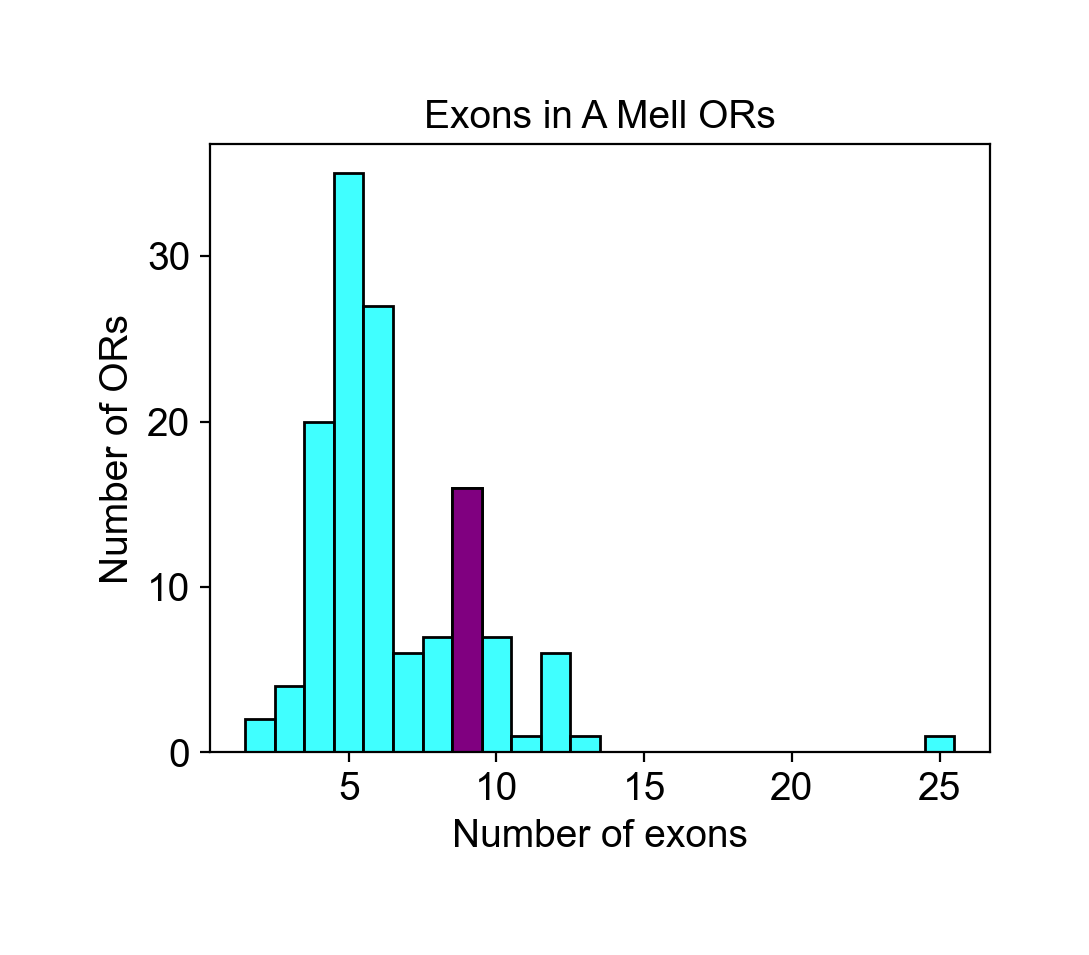

In [29]:
# Plot the distribution of exon numbers in ORs
white_plotting()
plt.figure(figsize=(5, 4))
sns.histplot(or_db["n_exons"], color="cyan", discrete=True)
plt.bar(9, or_db["n_exons"].value_counts()[9], color="purple", edgecolor="black", width=1)
plt.xlabel("Number of exons")
plt.ylabel("Number of ORs")
plt.title("Exons in A Mell ORs")
plt.show()

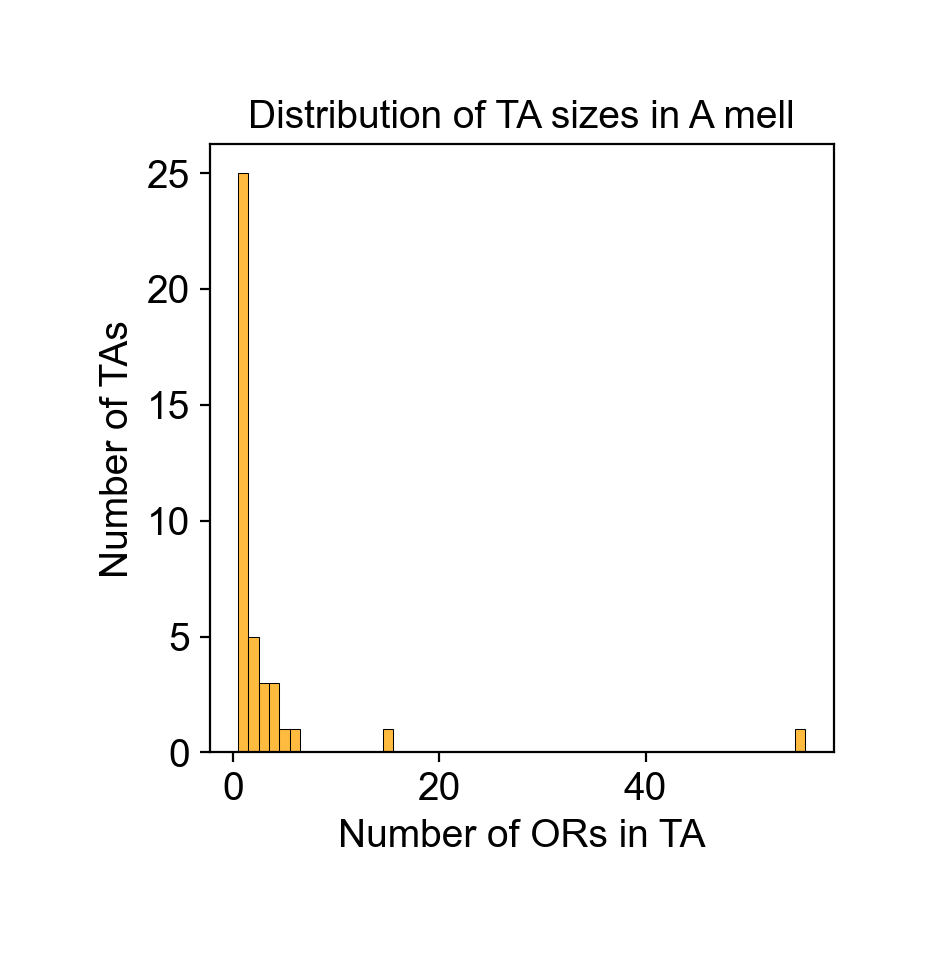

In [30]:
# Plot the distribution of TA sizes
first_rows = or_db.groupby('tandem_array').first()
white_plotting()
plt.figure(figsize=(4, 4))
sns.histplot(first_rows.ta_size, color="orange", discrete=True)
plt.xlabel("Number of ORs in TA")
plt.ylabel("Number of TAs")
plt.title("Distribution of TA sizes in A mell")
plt.show()

## Load scRNAseq Data

In [31]:
base_dir = "../raw-data/Amell/scRNAseq/"
samples = ["Forager", "Nurse", "NewlyEmerged"]
adatas = {}
for sample in samples:
    input_dir = base_dir + sample 
    adata = sc.read_10x_mtx(input_dir, var_names='gene_symbols', cache=True)  
    adata.var_names_make_unique()
    adata.obs["sample"] = sample
    adatas[sample] = adata

In [32]:
# Get cell IDs 
adatas["Forager"].obs["cell_id"] = [x + "-F" for x in adatas["Forager"].obs.index.tolist()]
adatas["Nurse"].obs["cell_id"] = [x + "-N" for x in adatas["Nurse"].obs.index.tolist()]
adatas["NewlyEmerged"].obs["cell_id"] = [x + "-NE" for x in adatas["NewlyEmerged"].obs.index.tolist()]

In [33]:
# Concatenate adatas into adata 
adata = adatas["Forager"].concatenate(adatas["Nurse"], adatas["NewlyEmerged"])
adata

AnnData object with n_obs × n_vars = 11517 × 12370
    obs: 'sample', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types'

In [34]:
# PCA 
sc.pp.pca(adata) 
print("Performed PCA")

Performed PCA


In [35]:
# Harmony Integration: When you have clear batch labels (e.g., different time points) and want to align datasets while preserving biological variability. 
sce.pp.harmony_integrate(adata, 'batch')

2025-07-09 12:56:03,134 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-09 12:56:04,077 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-09 12:56:04,096 - harmonypy - INFO - Iteration 1 of 10
2025-07-09 12:56:04,899 - harmonypy - INFO - Iteration 2 of 10
2025-07-09 12:56:05,723 - harmonypy - INFO - Iteration 3 of 10
2025-07-09 12:56:06,551 - harmonypy - INFO - Iteration 4 of 10
2025-07-09 12:56:07,355 - harmonypy - INFO - Iteration 5 of 10
2025-07-09 12:56:08,166 - harmonypy - INFO - Iteration 6 of 10
2025-07-09 12:56:08,972 - harmonypy - INFO - Iteration 7 of 10
2025-07-09 12:56:09,770 - harmonypy - INFO - Converged after 7 iterations


In [36]:
adata

AnnData object with n_obs × n_vars = 11517 × 12370
    obs: 'sample', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [37]:
timepoint = "NewlyEmerged"
#adata = adatas[timepoint]

In [38]:
# QC 
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 11517 × 12370
    obs: 'sample', 'cell_id', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'pca'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [39]:
# Filter genes and cells
sc.pp.filter_genes(adata, min_cells=2)  # Remove genes expressed in fewer than 10 cells
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering genes")

sc.pp.filter_cells(adata, min_genes=100)  # Remove cells with fewer than 200 genes expressed
print(f"Number of cells: {adata.n_obs}, number of genes: {adata.n_vars} after filtering cells")

Number of cells: 11517, number of genes: 11627 after filtering genes
Number of cells: 11495, number of genes: 11627 after filtering cells


In [40]:
# Verify that the gene names are in the transcriptome
all_genes = [gene for gene in list(tr.genes.keys())]
adata.var["in_tr"] = adata.var.index.isin(all_genes)
print(f"Identified {adata.var['in_tr'].sum()} genes in the transcriptome out of {adata.n_vars}")

Identified 11577 genes in the transcriptome out of 11627


In [41]:
# Verify that the gene names in the OR database are in the transcriptome
adata.var["in_or_db"] = adata.var.index.isin(or_db["gene_name"])
print(f"Identified {adata.var['in_or_db'].sum()} ORs in the snRNAseq data out of {or_db.shape[0]}")

Identified 121 ORs in the snRNAseq data out of 133


In [42]:
# Use 'gene_name_snrna' when querying ORs in adata 
adata.var["in_or_db"] = adata.var.index.isin(or_db["gene_name_snrna"])
print(f"Identified {adata.var['in_or_db'].sum()} ORs in the snRNAseq data out of {or_db.shape[0]}")

Identified 133 ORs in the snRNAseq data out of 133


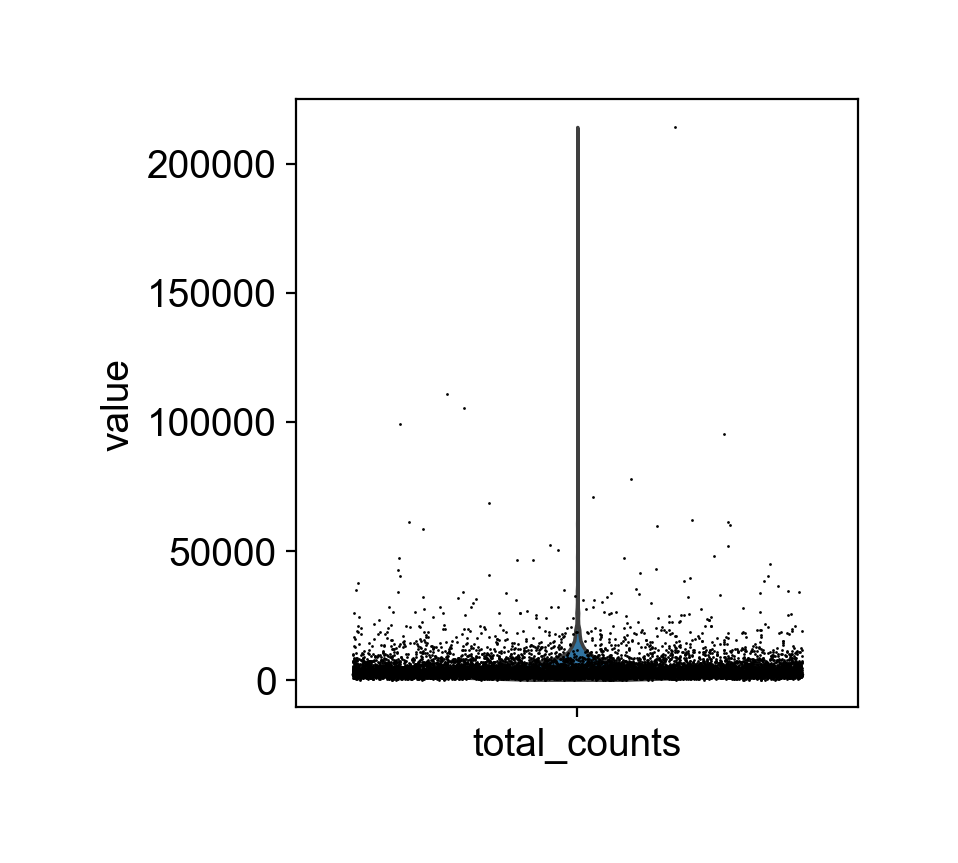

In [43]:
white_plotting()    
sc.pl.violin(adata, ['total_counts'], jitter=0.4, log=False)

In [44]:
# Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4) # Obir value 
print("Normalizing total counts per cell")

# Log-transform the data
sc.pp.log1p(adata)  
print("Log-transforming data")

Normalizing total counts per cell
Log-transforming data


In [45]:
# PCA 
sc.pp.pca(adata) 
print("Performed PCA")

Performed PCA


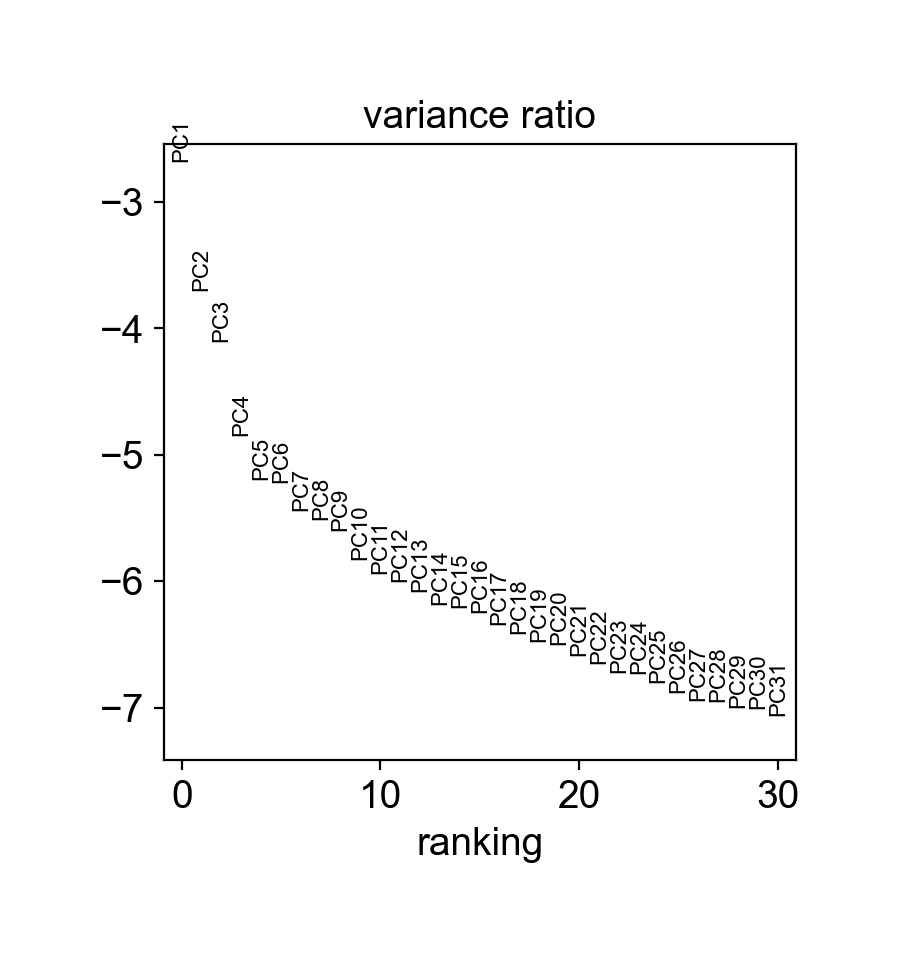

In [46]:
sc.pl.pca_variance_ratio(adata, log=True)

In [47]:
sc.pp.highly_variable_genes(adata, min_mean=0.001, max_mean=5, min_disp=0.5)

In [48]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30, use_rep="X_pca")

In [49]:
sc.tl.umap(adata) 
print("Computed UMAP")

Computed UMAP


In [50]:
sc.tl.leiden(adata, resolution=0.5) 
print("Performed Leiden clustering")

Performed Leiden clustering


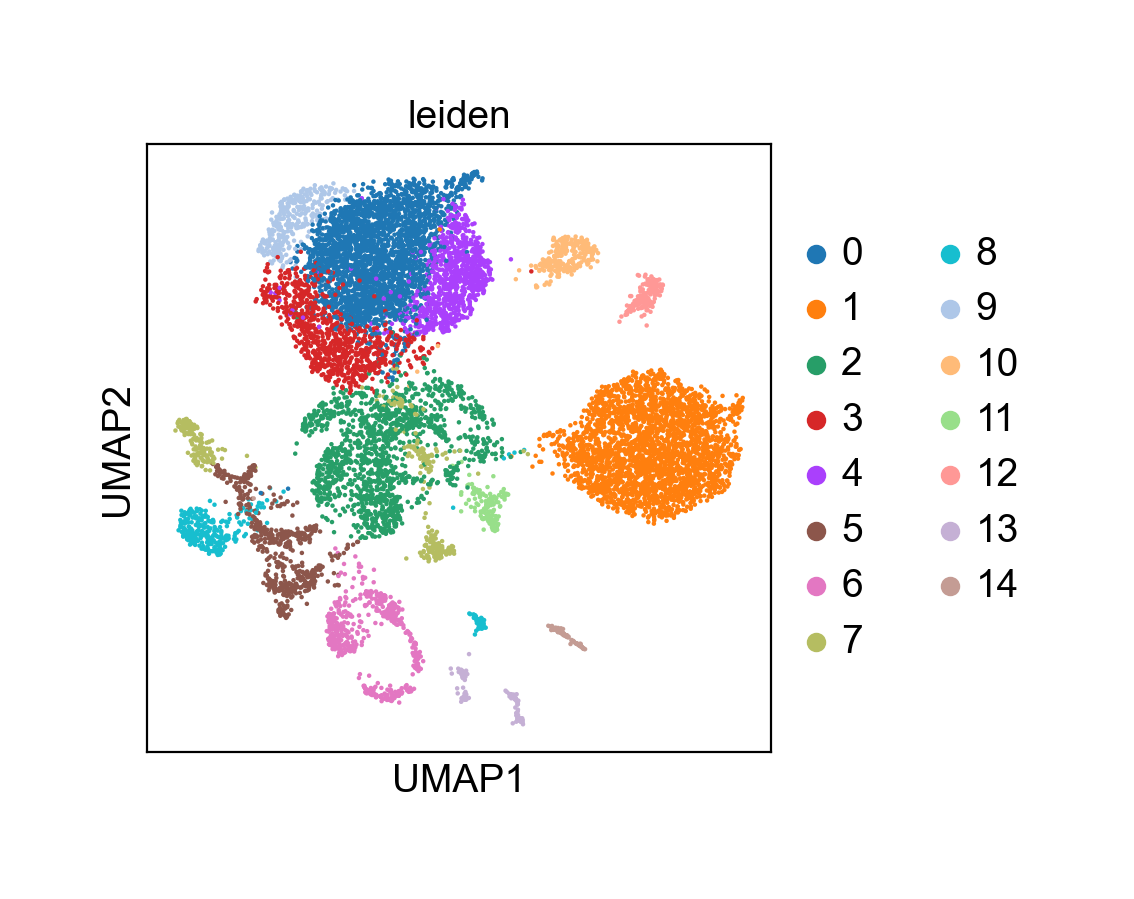

In [51]:
# Plot
sc.pl.umap(adata, color=["leiden"])

In [52]:
# Tandem array based assignment
tandem_array_matrix = pd.DataFrame(0, index=adata.obs_names, columns=or_db['tandem_array'].unique().astype(str))
for array in or_db['tandem_array'].unique():
    tandem_array_matrix[array] = adata[:, or_db[or_db['tandem_array'] == array]['gene_name_snrna']].X.sum(axis=1)

# Add the tandem array matrix to the data 
adata.obsm['tandem_array'] = tandem_array_matrix.values

# Assign clusters to cells based on the tandem array with the highest expression
adata.obs['tandem_array_cluster'] = tandem_array_matrix.idxmax(axis=1).values.astype(str) 

In [53]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name_snrna)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name_snrna] = adata[:,row['gene_name_snrna']].X.toarray().flatten()

# Drop Or2 from cell_or_expression
cell_or_expression = cell_or_expression.drop(columns='Or2')

In [54]:
# Assign valence TAs based on the max expression of the ORs in each cell
valence_ORs = cell_or_expression.idxmax(axis=1).values.tolist() 
valence_TAs = np.array([str(or_db.loc[or_db.gene_name_snrna == x, 'tandem_array'].values[0]) for x in valence_ORs]).astype(str)
adata.obs['valence_TA'] = valence_TAs 

## Ladder Example

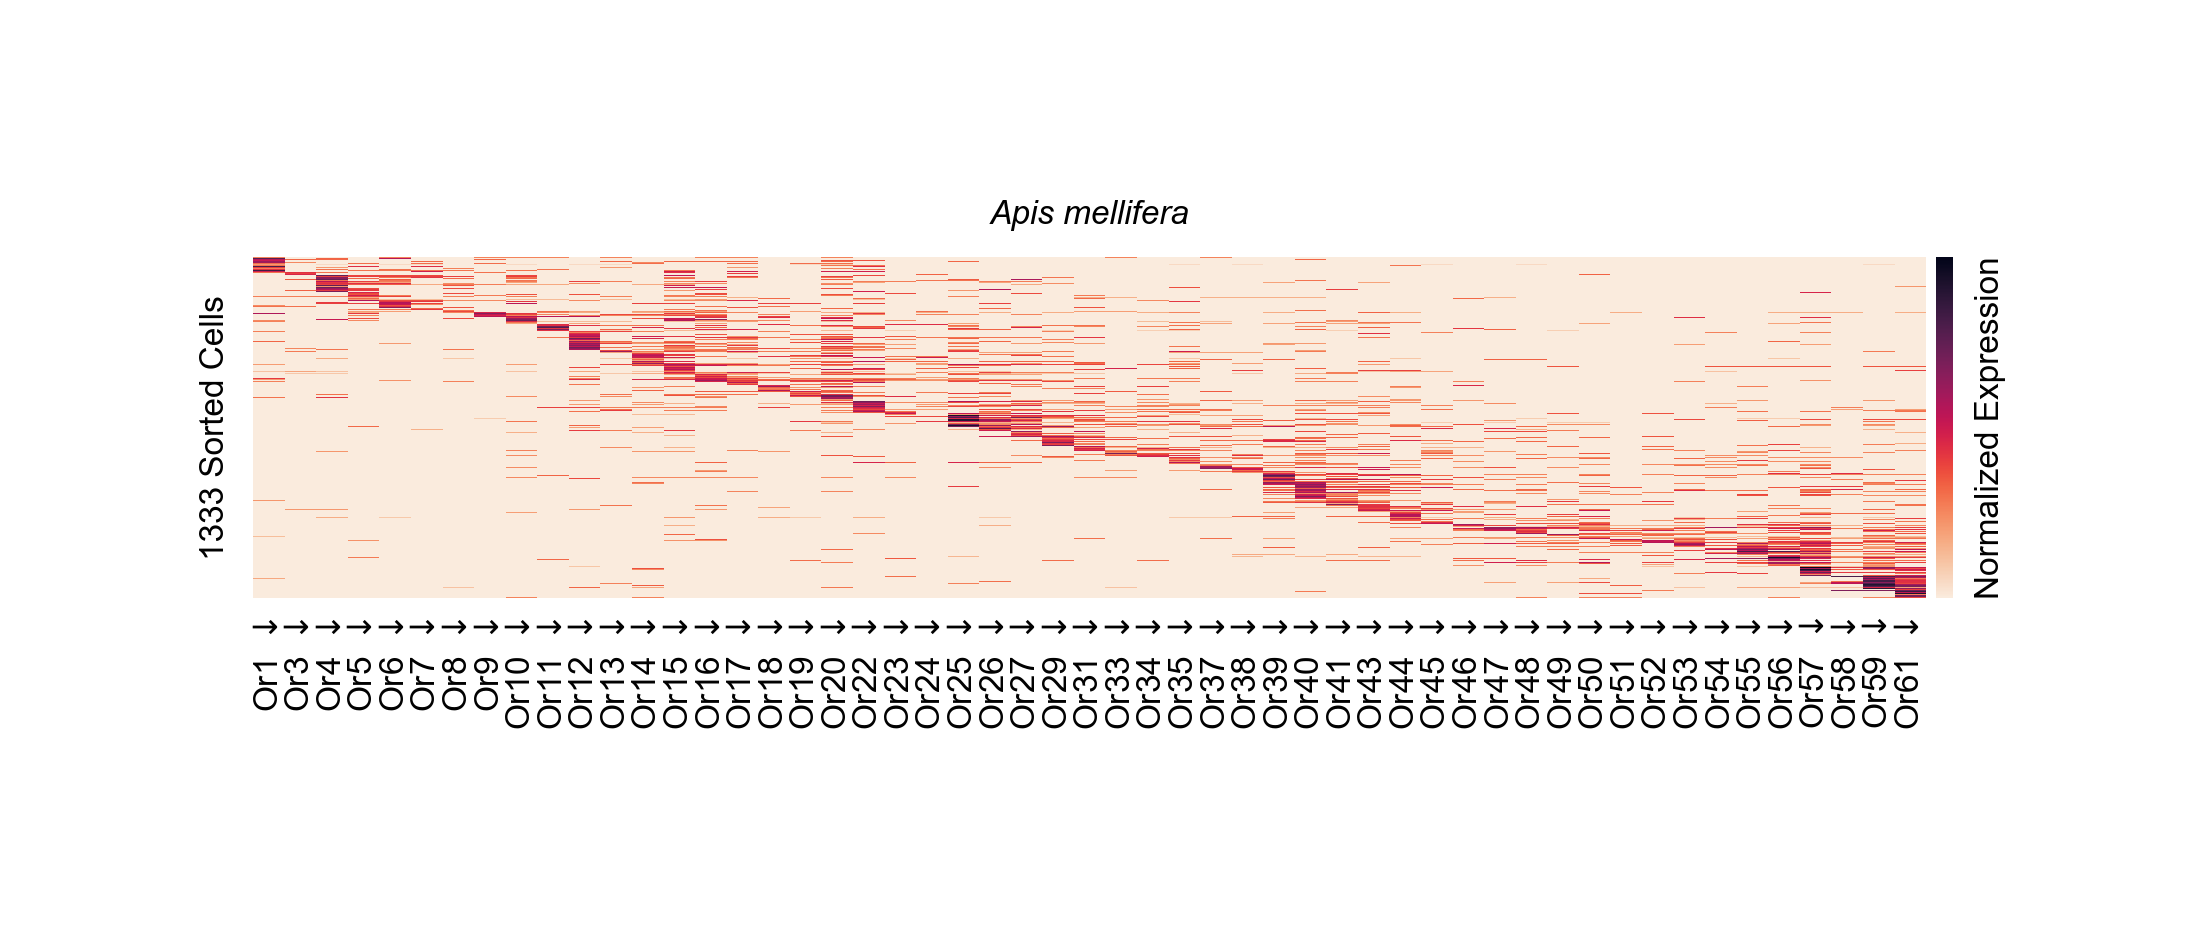

In [55]:
TA = 12

subset = or_db[or_db.tandem_array == TA]
genes = subset.gene_name_snrna.values
cells = adata[(adata.obs['sample']=='NewlyEmerged') & (adata.obs['tandem_array_cluster'] == str(TA))]
expression = pd.DataFrame(cells[:, genes].X.toarray(), columns=genes, index=cells.obs_names)
expression['top_or'] = expression.idxmax(axis=1)
expression['top_or'] = pd.Categorical(expression['top_or'], categories=genes, ordered=True)
expression = expression.sort_values('top_or', ascending=True)

# Plot a heatmap of the expression data, with or_db gene order on the x axis and expression on the y axis
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
fig, ax = plt.subplots(1, 1, figsize=(5.5, 1.75), dpi=200)
sns.heatmap(expression.iloc[:, :-1], 
            cmap=sns.color_palette("rocket_r", as_cmap=True), 
            ax=ax, 
            xticklabels=True, 
            yticklabels=False, 
            cbar_kws={'pad': 0.005}
            )

cbar = ax.collections[0].colorbar
cbar.set_ticks([])
cbar.set_label('Normalized Expression', fontsize=6) 

ax.set_ylabel(f'{cells.shape[0]} Sorted Cells', fontsize=6)
ax.set_xlabel('')
ax.set_title(f'Apis mellifera', fontsize=6, style='italic')

# Modify the x-tick labels: Remove Or5- prefix and add orientation
gene_names = subset.gene_name.values
alt_names = subset.alt_name.values
#$\it{text you want to show in italics}$
xticklabels = [f"{alt_names[i]} {tr.get_gene(gene_names[i]).strand}" for i in range(len(gene_names))]
xticklabels = [re.sub(r'(-)', r'$\\uparrow$', x) for x in xticklabels]
xticklabels = [re.sub(r'(\+)', r'$\\downarrow$', x) for x in xticklabels]
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=90, fontsize=6)
ax.xaxis.set_ticks_position('none')
ax.tick_params(axis='x', which='major', pad=0)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"../figures/Amell-T12-staircase.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

plt.show()

# lncRNA TSS Analysis

In [56]:
all_genes = [tr.get_gene(gene) for gene in tr.genes.keys() if len(tr.get_gene(gene).transcripts) > 0]
all_lncRNAs = [gene for gene in all_genes if gene.transcript_biotype == 'lnc_RNA']
len(all_lncRNAs), len(all_genes)

(1858, 12356)

In [57]:
def overlapping(chr1, start1, end1, chr2, start2, end2):
    return chr1 == chr2 and not (end1 < start2 or end2 < start1)

In [58]:
# Find nested lncRNAs within TAs 
or_db_no_orco = or_db.loc[~or_db.gene_name.str.contains('Or2')].reset_index(drop=True)
TAs = or_db_no_orco['tandem_array'].unique()
nested_lncRNAs = [] 

for ta_ in TAs: 
    # Get bounds of tandem array 
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(ta_)]
    # sort by start
    TA_genes = TA_genes.sort_values(by='start').reset_index(drop=True)
    TA_genes = TA_genes['gene_name']
    TA_chromosome = tr.get_gene(TA_genes.iloc[0]).chromosome
    first_gene_bounds = tr.get_gene(TA_genes.iloc[0]).get_transcript_longest_bounds().get_bounds()
    last_gene_bounds = tr.get_gene(TA_genes.iloc[-1]).get_transcript_longest_bounds().get_bounds()
    TA_bounds = [first_gene_bounds[0], last_gene_bounds[1]]
    
    for lncRNA in all_lncRNAs: 
        lnc_start, lnc_end = lncRNA.get_transcript_longest_bounds().get_bounds()
        lnc_strand = lncRNA.strand 
        #if lnc_start >= TA_bounds[0] and lnc_end <= TA_bounds[1] and lncRNA.chromosome == TA_chromosome: 
        if overlapping(TA_chromosome, TA_bounds[0], TA_bounds[1], lncRNA.chromosome, lnc_start, lnc_end):
            lnc_size = lnc_end - lnc_start
            nested_lncRNAs.append({'gene_name': lncRNA.name, 'TA': ta_, 'TA_location': f"{TA_chromosome}:{TA_bounds[0]}-{TA_bounds[1]}", 'lnc_strand': lnc_strand, 'lnc_size': lnc_size, 'lnc_start': lnc_start, 'lnc_end': lnc_end})

nested_lncRNAs = pd.DataFrame(nested_lncRNAs)
nested_lncRNAs

,gene_name,TA,TA_location,lnc_strand,lnc_size,lnc_start,lnc_end
0,LOC102656092,12,NC_037639.1:9976746-10152787,-,2812,10067130,10069942
1,LOC102656676,12,NC_037639.1:9976746-10152787,-,3577,10109678,10113255
2,LOC107966088,12,NC_037639.1:9976746-10152787,-,12206,10046889,10059095
3,LOC107966089,12,NC_037639.1:9976746-10152787,-,4935,10118308,10123243
4,LOC107966095,12,NC_037639.1:9976746-10152787,-,3415,10095847,10099262
...,...,...,...,...,...,...,...
6,LOC107966099,12,NC_037639.1:9976746-10152787,-,10192,9980987,9991179
7,LOC107966100,12,NC_037639.1:9976746-10152787,-,2879,9991212,9994091
8,LOC113218588,12,NC_037639.1:9976746-10152787,-,2491,10100712,10103203
9,LOC113218603,12,NC_037639.1:9976746-10152787,-,4690,10021401,10026091


Filter for lncRNAs present in both single cell datasets

In [59]:
# Remove lncRNAs that are not in the data 
nested_lncRNAs['in_data'] = nested_lncRNAs['gene_name'].isin(adata.var.index)
nested_lncRNAs = nested_lncRNAs.loc[nested_lncRNAs['in_data']]
nested_lncRNAs = nested_lncRNAs.reset_index(drop=True)
nested_lncRNAs.shape

(11, 8)

Identify the two ORs that flank the lncRNA 

In [60]:
or_db_no_orco = or_db[~or_db['gene_name'].str.contains('Or2')]
or_db_no_orco.shape

(129, 16)

In [61]:
# For each nested lncRNA, find all ORs that are upstream or downstream of the lncRNA TSS within the TA 
lnc_associated_ORs = [] 

for i, row in nested_lncRNAs.iterrows():
    # Get ORs in the TA
    TA_genes = or_db_no_orco.loc[or_db_no_orco['tandem_array'] == int(row.TA), 'gene_name']
    ORs_of_interest = [] 
    # For each gene, check if it is upstream or downstream of the lncRNA
    for gene in TA_genes: 
        gene_obj = tr.get_gene(gene) 
        gene_start, gene_end = gene_obj.get_transcript_longest_bounds().get_bounds()
        gene_strand = gene_obj.strand
        # Verify that the OR and lncRNA are on opposite strands 
        if gene_strand == row.lnc_strand: 
            continue 
        if gene_strand == "-" and row.lnc_strand == "+": 
            if gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
            elif gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
        elif gene_strand == "+" and row.lnc_strand == "-": 
            if gene_start > row.lnc_start: 
                ORs_of_interest.append([gene, "upstream", gene_start - row.lnc_start, gene_start, gene_end, gene_strand])
            elif gene_end < row.lnc_start: 
                ORs_of_interest.append([gene, "downstream", row.lnc_start - gene_start, gene_start, gene_end, gene_strand])
    
    # save to lnc_associated_ORs
    for or_name, location, distance, or_start, or_end, or_strand in ORs_of_interest:
        lnc_associated_ORs.append({'lncRNA': row.gene_name, 'lncRNA_size': row.lnc_size, 'TA': row.TA, 'or_name': or_name, 'location': location, 'tss2tss': distance, 'lnc_start': row.lnc_start, 'lnc_end': row.lnc_end, 'lnc_strand': row.lnc_strand, 'or_start': or_start, 'or_end': or_end, 'or_strand': or_strand})
    

lnc_associated_ORs = pd.DataFrame(lnc_associated_ORs)
lnc_associated_ORs

,lncRNA,lncRNA_size,TA,or_name,location,tss2tss,lnc_start,lnc_end,lnc_strand,or_start,or_end,or_strand
0,LOC102656092,2812,12,LOC725205,downstream,90384,10067130,10069942,-,9976746,9979176,+
1,LOC102656092,2812,12,LOC100577787,downstream,87086,10067130,10069942,-,9980044,9982278,+
2,LOC102656092,2812,12,Or4,downstream,84172,10067130,10069942,-,9982958,9984808,+
3,LOC102656092,2812,12,Or5,downstream,80132,10067130,10069942,-,9986998,9988716,+
4,LOC102656092,2812,12,LOC102655367,downstream,76939,10067130,10069942,-,9990191,9992152,+
...,...,...,...,...,...,...,...,...,...,...,...,...
493,LOC107965274,4903,22,Or105,upstream,12068,11128452,11133355,+,11116384,11118629,-
494,LOC107965274,4903,22,LOC102655147,upstream,3053,11128452,11133355,+,11125399,11128016,-
495,LOC107965274,4903,22,LOC102655180,downstream,919,11128452,11133355,+,11129371,11132235,-
496,LOC107965274,4903,22,LOC102656805,downstream,3804,11128452,11133355,+,11132256,11134536,-


In [62]:
# gene_name_snrna 
lnc_associated_ORs['or_name_snrna'] = lnc_associated_ORs['or_name'].apply(lambda x: or_db.loc[or_db['gene_name'] == x, 'gene_name_snrna'].values[0])

Measure expression of the OR in cells expressing the lncRNA, for both snRNAseq datasets

In [63]:
# For cells that express each lncRNA, measure the expression of the OR 
unique_lncs = lnc_associated_ORs['lncRNA'].unique()
lnc_associated_ORs['OR_coexpression'] = None
for unique_lnc in unique_lncs: 
    lnc_cell_indices = adata[:, unique_lnc].X > 0
    if lnc_cell_indices.sum() == 0: 
        continue
    for i, row in lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == unique_lnc].iterrows(): 
        or_coexpression = adata[lnc_cell_indices, row['or_name_snrna']].X.mean()
        lnc_associated_ORs.at[i, 'OR_coexpression'] = or_coexpression if or_coexpression > 0 else 0

lnc_associated_ORs

,lncRNA,lncRNA_size,TA,or_name,location,tss2tss,lnc_start,lnc_end,lnc_strand,or_start,or_end,or_strand,or_name_snrna,OR_coexpression
0,LOC102656092,2812,12,LOC725205,downstream,90384,10067130,10069942,-,9976746,9979176,+,LOC725205,0.032753
1,LOC102656092,2812,12,LOC100577787,downstream,87086,10067130,10069942,-,9980044,9982278,+,LOC100577787,0.014146
2,LOC102656092,2812,12,Or4,downstream,84172,10067130,10069942,-,9982958,9984808,+,Or4,0.029459
3,LOC102656092,2812,12,Or5,downstream,80132,10067130,10069942,-,9986998,9988716,+,Or5,0.031751
4,LOC102656092,2812,12,LOC102655367,downstream,76939,10067130,10069942,-,9990191,9992152,+,LOC102655367,0.036803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,LOC107965274,4903,22,Or105,upstream,12068,11128452,11133355,+,11116384,11118629,-,Or105,1.058699
494,LOC107965274,4903,22,LOC102655147,upstream,3053,11128452,11133355,+,11125399,11128016,-,LOC102655147,0.620981
495,LOC107965274,4903,22,LOC102655180,downstream,919,11128452,11133355,+,11129371,11132235,-,LOC102655180,0.347531
496,LOC107965274,4903,22,LOC102656805,downstream,3804,11128452,11133355,+,11132256,11134536,-,LOC102656805,0.100354


Adjust distances so that upstream is negative and downstream is positive

In [64]:
lnc_associated_ORs['distance_adjusted'] = lnc_associated_ORs.apply(lambda x: x['tss2tss'] if x['location'] == 'downstream' else -x['tss2tss'], axis=1)
lnc_associated_ORs

,lncRNA,lncRNA_size,TA,or_name,location,tss2tss,lnc_start,lnc_end,lnc_strand,or_start,or_end,or_strand,or_name_snrna,OR_coexpression,distance_adjusted
0,LOC102656092,2812,12,LOC725205,downstream,90384,10067130,10069942,-,9976746,9979176,+,LOC725205,0.032753,90384
1,LOC102656092,2812,12,LOC100577787,downstream,87086,10067130,10069942,-,9980044,9982278,+,LOC100577787,0.014146,87086
2,LOC102656092,2812,12,Or4,downstream,84172,10067130,10069942,-,9982958,9984808,+,Or4,0.029459,84172
3,LOC102656092,2812,12,Or5,downstream,80132,10067130,10069942,-,9986998,9988716,+,Or5,0.031751,80132
4,LOC102656092,2812,12,LOC102655367,downstream,76939,10067130,10069942,-,9990191,9992152,+,LOC102655367,0.036803,76939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,LOC107965274,4903,22,Or105,upstream,12068,11128452,11133355,+,11116384,11118629,-,Or105,1.058699,-12068
494,LOC107965274,4903,22,LOC102655147,upstream,3053,11128452,11133355,+,11125399,11128016,-,LOC102655147,0.620981,-3053
495,LOC107965274,4903,22,LOC102655180,downstream,919,11128452,11133355,+,11129371,11132235,-,LOC102655180,0.347531,919
496,LOC107965274,4903,22,LOC102656805,downstream,3804,11128452,11133355,+,11132256,11134536,-,LOC102656805,0.100354,3804


In [65]:
# get unique lncRNAs
lnc_associated_ORs['lncRNA'].unique()

array(['LOC102656092', 'LOC102656676', 'LOC107966088', 'LOC107966089',
       'LOC107966095', 'LOC107966098', 'LOC107966099', 'LOC107966100',
       'LOC113218588', 'LOC113218603', 'LOC107965274'], dtype=object)

In [66]:
lncRNA = 'LOC102656092'
rows = lnc_associated_ORs.loc[lnc_associated_ORs['lncRNA'] == lncRNA]
upstream_ORs = rows.loc[rows['location'] == 'upstream']['or_name'].values
downstream_ORs = rows.loc[rows['location'] == 'downstream']['or_name'].values
rows

,lncRNA,lncRNA_size,TA,or_name,location,tss2tss,lnc_start,lnc_end,lnc_strand,or_start,or_end,or_strand,or_name_snrna,OR_coexpression,distance_adjusted
0,LOC102656092,2812,12,LOC725205,downstream,90384,10067130,10069942,-,9976746,9979176,+,LOC725205,0.032753,90384
1,LOC102656092,2812,12,LOC100577787,downstream,87086,10067130,10069942,-,9980044,9982278,+,LOC100577787,0.014146,87086
2,LOC102656092,2812,12,Or4,downstream,84172,10067130,10069942,-,9982958,9984808,+,Or4,0.029459,84172
3,LOC102656092,2812,12,Or5,downstream,80132,10067130,10069942,-,9986998,9988716,+,Or5,0.031751,80132
4,LOC102656092,2812,12,LOC102655367,downstream,76939,10067130,10069942,-,9990191,9992152,+,LOC102655367,0.036803,76939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,LOC102656092,2812,12,Or56,upstream,67104,10067130,10069942,-,10134234,10136939,+,Or56,0.442796,-67104
46,LOC102656092,2812,12,Or57,upstream,70321,10067130,10069942,-,10137451,10142473,+,Or57,0.49849,-70321
47,LOC102656092,2812,12,Or58,upstream,75787,10067130,10069942,-,10142917,10144562,+,Or58,0.226593,-75787
48,LOC102656092,2812,12,LOC102653637,upstream,77761,10067130,10069942,-,10144891,10147722,+,LOC102653637,0.585716,-77761


Chromosome: NC_037639.1, Start: 9976646, End: 10152887


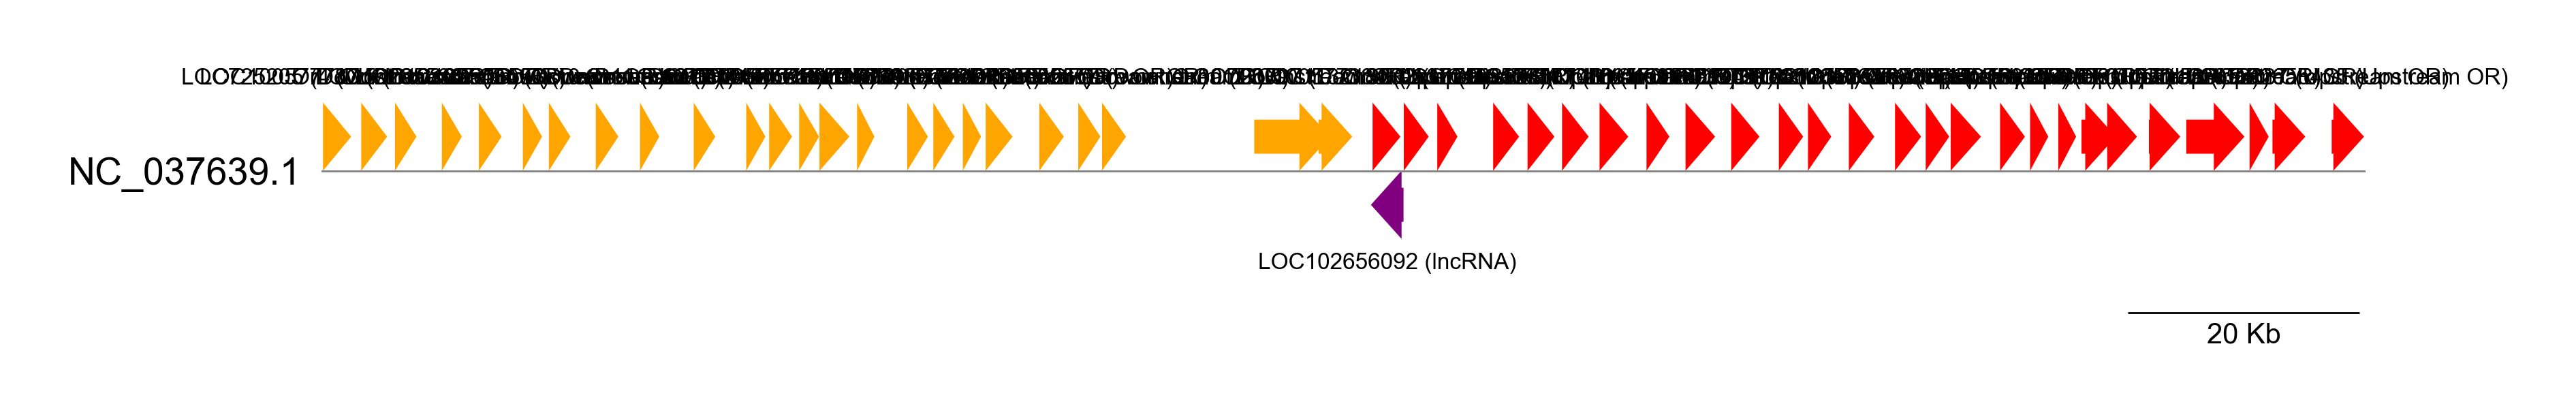

In [67]:
chromosome = tr.get_gene(lncRNA).chromosome
start = min(rows.or_start)-100
end = max(rows.or_end)+100
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

white_plotting()
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

fontsize=12 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)))
#track.add_sublabel(size=fontsize)

# Add gene models to plot 
for gene in [lncRNA] + list(upstream_ORs) + list(downstream_ORs):
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    if gene in upstream_ORs:
        color = 'red'
        label = f'{gene} (Upstream OR)'
    elif gene in downstream_ORs:
        color = 'orange'
        label = f'{gene} (Downstream OR)'
    elif gene == lncRNA: 
        color = 'purple'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig()
plt.show()

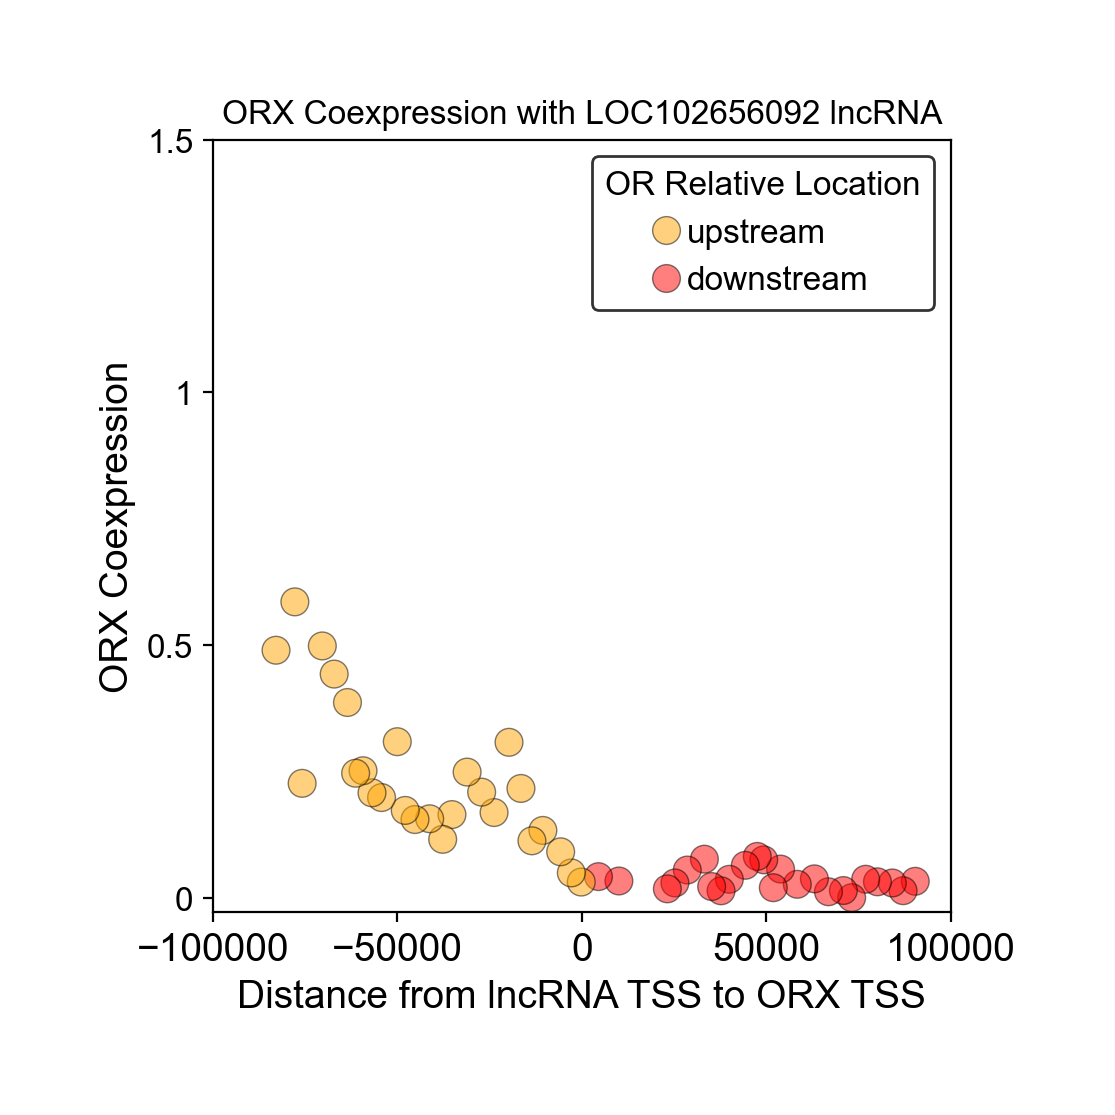

In [68]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
palette=['orange', 'red']
sns.scatterplot(data=rows, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=100, legend=True, lw=0.5, edgecolor='black', alpha=0.5)
ax.set_xlabel('Distance from lncRNA TSS to ORX TSS')
ax.set_ylabel('ORX Coexpression')
ax.set_title(f'ORX Coexpression with {lncRNA} lncRNA', fontsize=fontsize)
ax.set_xlim(-100_000, 100_000)
#ax.set_xticks([-20_000, -10_000, 0, 10_000, 20_000])
#ax.set_xticklabels(['-20kb', '-10kb', '0', '10kb', '20kb'], fontsize=fontsize)
ax.legend(title='OR Relative Location', loc='upper right', fontsize=fontsize, title_fontsize=fontsize)
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_yticklabels([0, 0.5, 1, 1.5], fontsize=fontsize)

plt.tight_layout()
plt.show()

In [69]:
# Plot the number of lncRNAs split by TA 
ta, counts = np.unique(nested_lncRNAs['TA'], return_counts=True)
counts = pd.DataFrame({'TA': ta, 'num_lnc': counts})
counts = counts.sort_values(by='num_lnc', ascending=False).reset_index(drop=True)
counts['num_ORs'] = counts['TA'].apply(lambda x: or_db_no_orco.loc[or_db_no_orco.tandem_array == x].shape[0])
counts

,TA,num_lnc,num_ORs
0,12,10,50
1,22,1,5


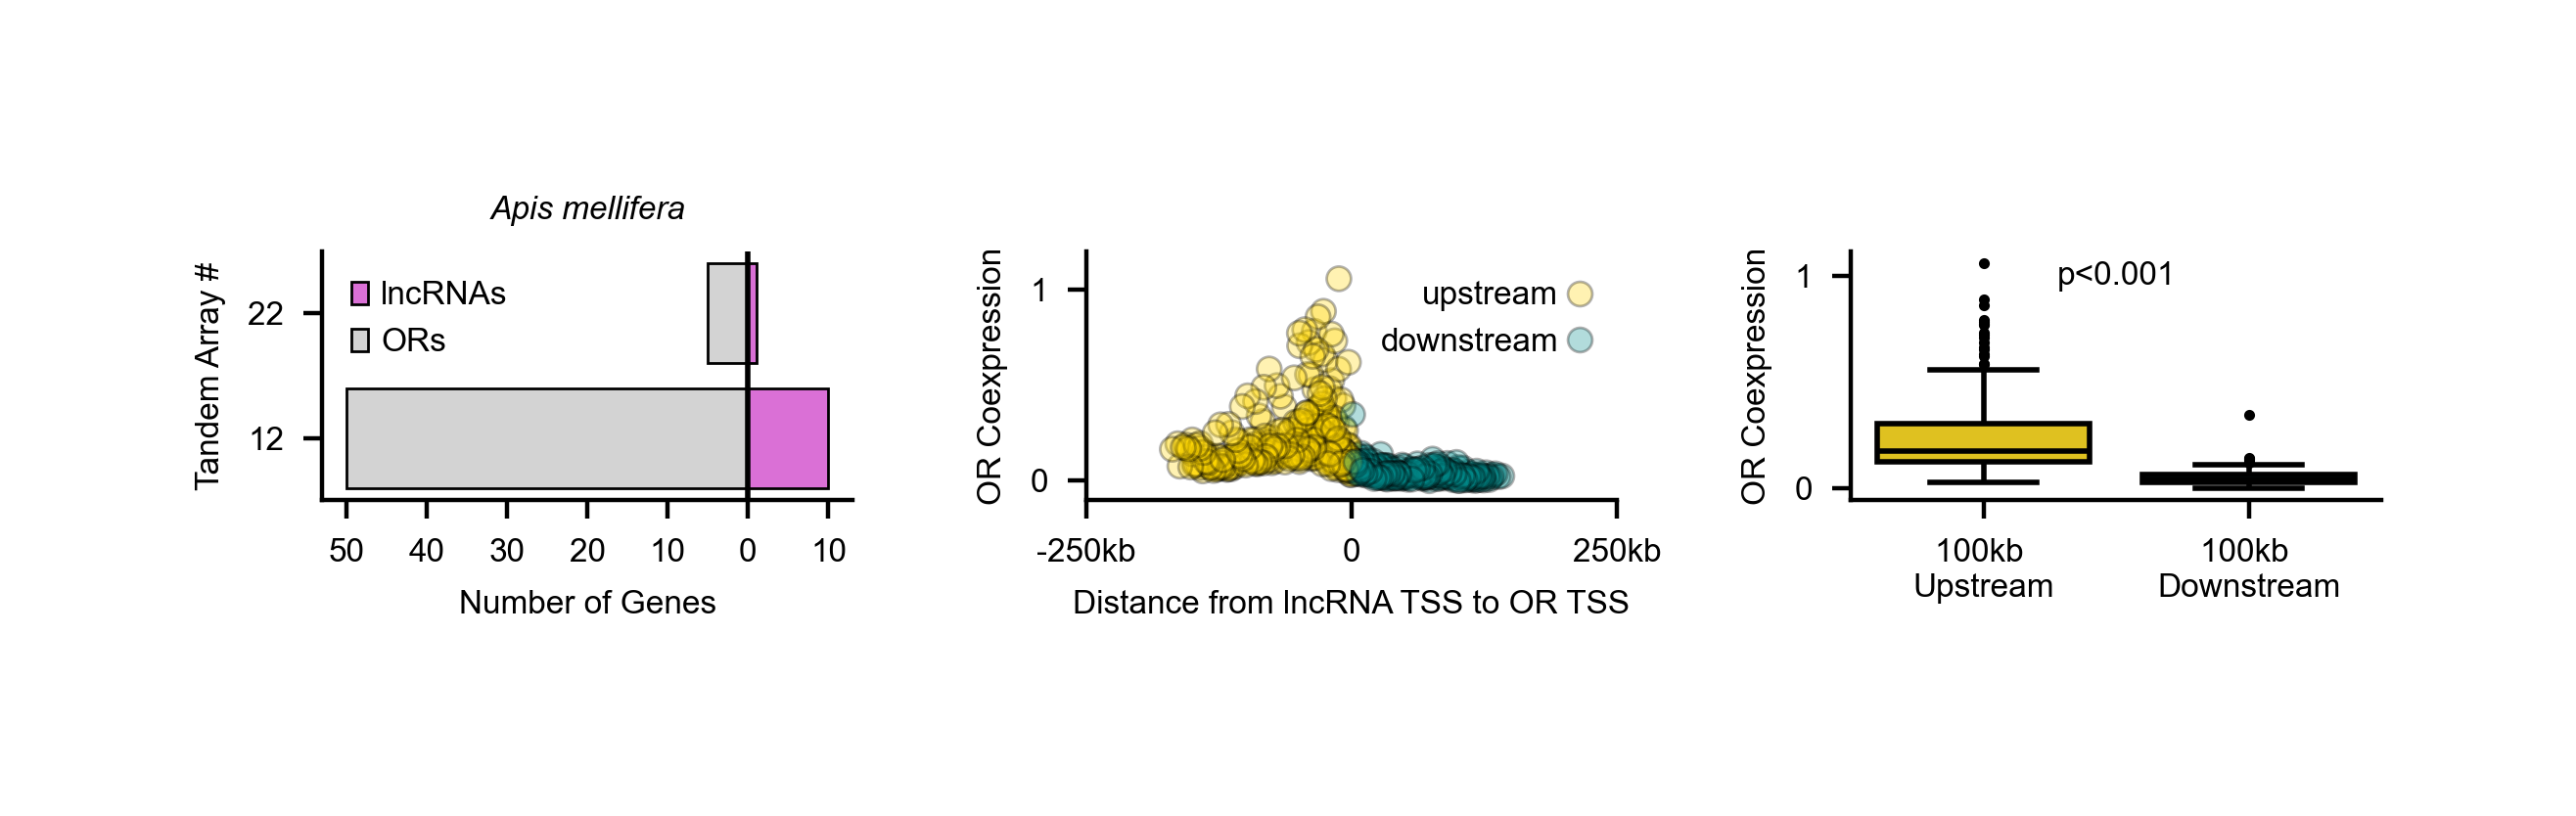

In [70]:
# Scatter plot of coexpression vs distance_adjusted, two subplots for P1 and P14, with KDE 
white_plotting()
fontsize=6
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, axs = plt.subplots(1, 3, figsize=(6, 1.5), dpi=200)

ax = axs[0]

y_labels = counts['TA']
y_pos = np.arange(len(y_labels))

ax.barh(y_pos, counts['num_lnc'], color='orchid', label='lncRNAs', linewidth=0.5, edgecolor='black')
ax.barh(y_pos, -counts['num_ORs'], color='lightgrey', label='ORs', linewidth=0.5, edgecolor='black')

# Y axis 
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=fontsize)
ax.set_ylabel('Tandem Array #', fontsize=fontsize)
ax.set_title("Apis mellifera", fontsize=6, style='italic')

# X labels 
ax.set_xticks([-50, -40, -30, -20, -10, 0, 10], labels=[50, 40, 30, 20, 10, 0, 10], fontsize=fontsize)
ax.set_xlabel('')
ax.axvline(0, color='black', linewidth=1) 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Number of Genes", fontsize=fontsize)
ax.legend(loc='upper left', fontsize=fontsize, frameon=False)

palette=['gold', 'darkcyan']
ax = axs[1] 
sns.scatterplot(data=lnc_associated_ORs, x='distance_adjusted', y="OR_coexpression", ax=ax, hue='location', hue_order=['upstream', 'downstream'], palette=palette, s=20, legend=True, lw=0.5, edgecolor='black', alpha=0.3)
ax.set_xlabel('Distance from lncRNA TSS to OR TSS', fontsize=fontsize)
ax.set_ylabel('OR Coexpression', fontsize=fontsize)
ax.set_xlim(-250_000, 250_000)
ax.set_xticks([-250_000, 0, 250_000], labels=['-250kb', '0', '250kb'], fontsize=fontsize)
ax.set_yticks([0, 1], labels=[0, 1], fontsize=fontsize)
ax.set_ylim(-0.1, 1.2)
ax.legend(loc='upper right', fontsize=fontsize, frameon=False, markerfirst=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = axs[2]
max_distance = 100_000
data_subset=lnc_associated_ORs[lnc_associated_ORs['tss2tss'] < max_distance]
labels = ['100kb \nUpstream', '100kb \nDownstream']
# Plot box plot of OR coexpression by location and add stats 
palette=['gold', 'darkcyan']
bx = sns.boxplot(data=data_subset, x='location', y='OR_coexpression', ax=ax, palette=palette, hue_order=['upstream', 'downstream'], order=['upstream', 'downstream'], linewidth=1, linecolor='black', fliersize=1)
ax.set_xlabel('')
ax.set_ylabel('OR Coexpression', fontsize=fontsize)
ax.set_xticks([0, 1], labels=labels, fontsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 1], labels=[0, 1], fontsize=fontsize)

# Rank sum test 
upstream = data_subset.loc[data_subset['location'] == 'upstream', 'OR_coexpression']
downstream = data_subset.loc[data_subset['location'] == 'downstream', 'OR_coexpression']
from scipy.stats import ranksums
stat, p = ranksums(upstream, downstream)
p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
plt.text(0.5, 0.9, p_value_str, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

plt.tight_layout()
plt.savefig(f"../figures/Amell-lncRNA-ORX-coexpression.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

## Identify cells with valence OR in a tandem array that has a lncRNA 

In [71]:
# Make a dataframe with cell ID in a column and individual columns for each OR 
cell_or_expression = pd.DataFrame(index=adata.obs.index, columns=or_db.gene_name_snrna)
for i, row in or_db.iterrows(): 
    cell_or_expression[row.gene_name_snrna] = adata[:,row['gene_name_snrna']].X.toarray().flatten()

# Drop Or2 from cell_or_expression
cell_or_expression = cell_or_expression.drop(columns='Or2')

In [72]:
# Find the highest-expressing OR in each cell 
cell_valence_OR = cell_or_expression.idxmax(axis=1)
cell_valence_OR = cell_valence_OR.reset_index()
cell_valence_OR.columns = ['cell_index', 'valence_OR']
cell_valence_OR['valence_OR_tr'] = cell_valence_OR['valence_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'gene_name'].values[0])
cell_valence_OR['tandem_array'] = cell_valence_OR['valence_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'tandem_array'].values[0])
cell_valence_OR['or_strand'] = cell_valence_OR['valence_OR_tr'].apply(lambda x: tr.get_gene(x).strand)
cell_valence_OR

,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand
0,AAACAGCCACGGTTTA-1-0,LOC102653637,LOC102653637,12,+
1,AAACATGCAAGTTATC-1-0,LOC102656838,LOC102656838,24,+
2,AAACATGCAGTTGCGT-1-0,Or4,Or4,12,+
3,AAACATGCATCACTTC-1-0,LOC102655559,LOC102655559,10,+
4,AAACATGCATTGGGAG-1-0,LOC100577590,LOC100577590,12,+
...,...,...,...,...,...
11490,TTTGTGTTCTGCAAAC-1-2,LOC725205,LOC725205,12,+
11491,TTTGTTGGTAATCCCT-1-2,Or57,Or57,12,+
11492,TTTGTTGGTATACTGG-1-2,LOC107966050,LOC107966050,2,-
11493,TTTGTTGGTCGCATAA-1-2,Or55,Or55,12,+


In [73]:
# count rows where valence_OR != valence_OR_tr
cell_valence_OR[cell_valence_OR['valence_OR'] != cell_valence_OR['valence_OR_tr']].shape

(431, 5)

In [74]:
# Remove cells that do not have a lncRNA in the tandem array 
cell_valence_OR = cell_valence_OR[cell_valence_OR['tandem_array'].isin(nested_lncRNAs['TA'])].reset_index(drop=True)
cell_valence_OR

,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand
0,AAACAGCCACGGTTTA-1-0,LOC102653637,LOC102653637,12,+
1,AAACATGCAGTTGCGT-1-0,Or4,Or4,12,+
2,AAACATGCATTGGGAG-1-0,LOC100577590,LOC100577590,12,+
3,AAACCAACATGTGGGA-1-0,LOC113218533,LOC113218533,12,+
4,AAACCGAAGCATGTCG-1-0,Or105,Or105,22,-
...,...,...,...,...,...
4538,TTTGTGTTCGTTAACA-1-2,Or26,Or26,12,+
4539,TTTGTGTTCTGCAAAC-1-2,LOC725205,LOC725205,12,+
4540,TTTGTTGGTAATCCCT-1-2,Or57,Or57,12,+
4541,TTTGTTGGTCGCATAA-1-2,Or55,Or55,12,+


## Assign lncRNAs to valence ORs 
- Assert that the lncRNA and valence OR are on opposite strands 
- Assert that all transcript isoforms have a 3' end that is upstream of the OR TSS 
- Assert that min distance from the lncRNA 3' end (across all transcript isoforms) to the TSS is less than 10kb 
- Only save the lncRNA with the minimum `tss_2_lnc_end` distance 
- Remove cells where no lncRNA was assigned 
- Save expression of lncRNA and valence OR for each cell 

In [75]:
# For each cell and valence OR, look for a lncRNA whose 3' end is upstream of the OR TSS and whose 5' end is closest to the OR TSS 
max_distance = 10_000
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]):
    or_bounds = tr.get_gene(row['valence_OR_tr']).get_transcript_longest_cds().get_bounds()
    or_tss = or_bounds[0] if row['or_strand'] == "+" else or_bounds[1]
    # Get lncRNAs in the TA
    relevant_lncRNAs = nested_lncRNAs[nested_lncRNAs['TA'] == row['tandem_array']]
    relevant_lncRNAs['tss2tss'] = None
    relevant_lncRNAs['all_upstream'] = None
    for j, lncRNA in relevant_lncRNAs.iterrows():
        # check that strands are opposite 
        if row['or_strand'] == lncRNA['lnc_strand']:
            continue
        # get the bounds of the lncRNA 
        lnc_transcripts = tr.get_gene(lncRNA['gene_name']).transcripts 
        end_ind = 1 if lncRNA['lnc_strand'] == "+" else 0
        lnc_ends = [transcript.get_bounds()[end_ind] for transcript in lnc_transcripts]
        lnc_starts = [transcript.get_bounds()[1-end_ind] for transcript in lnc_transcripts]
        # Check that all transcripts have a 3' end upstream of the OR TSS
        all_upstream = all([lnc_end < or_tss for lnc_end in lnc_ends]) if row['or_strand'] == "+" else all([lnc_end > or_tss for lnc_end in lnc_ends])
        if all_upstream: 
            #tss_to_tss = min([abs(or_tss - lnc_start) for lnc_start in lnc_starts])
            tss_to_tss = min([(or_tss - lnc_start) for lnc_start in lnc_starts]) if row['or_strand'] == "+" else min([lnc_start - or_tss for lnc_start in lnc_starts])
            tss_2_lnc_end = min([abs(lnc_end - or_tss) for lnc_end in lnc_ends])
            relevant_lncRNAs.at[j, 'tss_2_lnc_end'] = tss_2_lnc_end
            relevant_lncRNAs.at[j, 'tss2tss'] = tss_to_tss
            relevant_lncRNAs.at[j, 'all_upstream'] = True
    # Save the lncRNA with the smallest tss2tss
    if relevant_lncRNAs.shape[0] > 0 and np.sum(relevant_lncRNAs['all_upstream']) > 0:
        relevant_lncRNAs = relevant_lncRNAs[relevant_lncRNAs['all_upstream']==True]
        relevant_lncRNAs = relevant_lncRNAs.iloc[np.argmin(relevant_lncRNAs['tss_2_lnc_end']), :]
        # Verify tss_2_lnc_end < max_distance 
        if relevant_lncRNAs['tss_2_lnc_end'] > max_distance: 
            continue
        cell_valence_OR.at[i, 'lncRNA'] = relevant_lncRNAs['gene_name']
        cell_valence_OR.at[i, 'tss_2_lnc_end'] = relevant_lncRNAs['tss_2_lnc_end']
        cell_valence_OR.at[i, 'tss2tss'] = relevant_lncRNAs['tss2tss']
        cell_valence_OR.at[i, 'lnc_strand'] = relevant_lncRNAs['lnc_strand']

cell_valence_OR

100%|██████████| 4543/4543 [00:05<00:00, 828.31it/s]


,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand,lncRNA,tss_2_lnc_end,tss2tss,lnc_strand
0,AAACAGCCACGGTTTA-1-0,LOC102653637,LOC102653637,12,+,NaN,NaN,NaN,NaN
1,AAACATGCAGTTGCGT-1-0,Or4,Or4,12,+,LOC107966099,1971.0,-8221.0,-
2,AAACATGCATTGGGAG-1-0,LOC100577590,LOC100577590,12,+,NaN,NaN,NaN,NaN
3,AAACCAACATGTGGGA-1-0,LOC113218533,LOC113218533,12,+,LOC113218588,7643.0,5152.0,-
4,AAACCGAAGCATGTCG-1-0,Or105,Or105,22,-,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4538,TTTGTGTTCGTTAACA-1-2,Or26,Or26,12,+,LOC107966088,2146.0,-10060.0,-
4539,TTTGTGTTCTGCAAAC-1-2,LOC725205,LOC725205,12,+,NaN,NaN,NaN,NaN
4540,TTTGTTGGTAATCCCT-1-2,Or57,Or57,12,+,NaN,NaN,NaN,NaN
4541,TTTGTTGGTCGCATAA-1-2,Or55,Or55,12,+,NaN,NaN,NaN,NaN


In [76]:
print(f"Dropped {cell_valence_OR[cell_valence_OR.tss_2_lnc_end < 0].shape[0]} rows where tss_2_lnc_end is negative")
cell_valence_OR = cell_valence_OR[cell_valence_OR.tss_2_lnc_end > 0].reset_index(drop=True)
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)
cell_valence_OR

Dropped 0 rows where tss_2_lnc_end is negative


,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand,lncRNA,tss_2_lnc_end,tss2tss,lnc_strand
0,AAACATGCAGTTGCGT-1-0,Or4,Or4,12,+,LOC107966099,1971.0,-8221.0,-
1,AAACCAACATGTGGGA-1-0,LOC113218533,LOC113218533,12,+,LOC113218588,7643.0,5152.0,-
2,AAACCGGCAGCAAGGC-1-0,Or9,Or9,12,+,LOC107966098,5577.0,-3654.0,-
3,AAACGTACAATCCTAG-1-0,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-
4,AAAGCAAGTAACCACA-1-0,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-
...,...,...,...,...,...,...,...,...,...
1641,TTTGGCTGTAAAGCAA-1-2,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-
1642,TTTGGCTGTTAGGCTA-1-2,LOC102655553,LOC102655553,12,+,LOC107966098,1530.0,-7701.0,-
1643,TTTGGTAAGTTATGTG-1-2,Or26,Or26,12,+,LOC107966088,2146.0,-10060.0,-
1644,TTTGTCCCACTGGCCA-1-2,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-


In [77]:
# Get expression of lncRNA and valence OR in each cell 
cell_valence_OR['lncRNA_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['lncRNA']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['valence_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['valence_OR']].X.toarray().flatten()[0], axis=1)

## Get ORs upstream and downstream of the valence OR 
- Assert that the valence OR is not at the start or the end of the tandem array (ensuring it has both a downstream and upstream OR)
- Assert that the valence OR and both it's upstream and downstream ORs are on the same strand 
- Save the expression of both the upstream and downstream ORs for each cell 

In [78]:
# Get upstream and downstream ORs 
for i, row in tqdm(cell_valence_OR.iterrows(), total=cell_valence_OR.shape[0]): 
    valence_strand = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'strand'].values[0]
    valence_tss = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'start'].values[0]
    other_ORs = or_db.loc[or_db['tandem_array'] == row['tandem_array']] 
    valence_index = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'ta_index'].values[0]
    TA_size = or_db.loc[or_db['gene_name'] == row['valence_OR_tr'], 'ta_size'].values[0]
    # if or's index is 1 or ta_index, continue 
    if valence_index == 0 or valence_index == TA_size:
        continue
    if valence_tss == np.min(other_ORs['start']) or valence_tss == np.max(other_ORs['start']):
        continue
    if valence_strand == '+': 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
    else: 
        # find OR in other_ORs that is closest to the start of valence_OR
        upstream_OR = other_ORs[other_ORs['start'] > valence_tss].sort_values(by='start').iloc[0]
        downstream_OR = other_ORs[other_ORs['start'] < valence_tss].sort_values(by='start', ascending=False).iloc[0]
    cell_valence_OR.at[i, 'upstream_OR'] = upstream_OR['gene_name_snrna']
    cell_valence_OR.at[i, 'downstream_OR'] = downstream_OR['gene_name_snrna']
cell_valence_OR

100%|██████████| 1646/1646 [00:01<00:00, 1145.05it/s]


,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand,lncRNA,tss_2_lnc_end,tss2tss,lnc_strand,lncRNA_expression,valence_OR_expression,upstream_OR,downstream_OR
0,AAACATGCAGTTGCGT-1-0,Or4,Or4,12,+,LOC107966099,1971.0,-8221.0,-,0.000000,2.347059,LOC100577787,Or5
1,AAACCAACATGTGGGA-1-0,LOC113218533,LOC113218533,12,+,LOC113218588,7643.0,5152.0,-,0.000000,2.447843,LOC100576881,LOC100576816
2,AAACCGGCAGCAAGGC-1-0,Or9,Or9,12,+,LOC107966098,5577.0,-3654.0,-,0.520226,0.520226,LOC102655553,Or10
3,AAACGTACAATCCTAG-1-0,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-,0.000000,2.409798,LOC113218602,Or37
4,AAAGCAAGTAACCACA-1-0,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-,0.000000,1.710747,LOC113218602,Or37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,TTTGGCTGTAAAGCAA-1-2,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,0.000000,1.166710,Or9,Or11
1642,TTTGGCTGTTAGGCTA-1-2,LOC102655553,LOC102655553,12,+,LOC107966098,1530.0,-7701.0,-,2.720489,1.213317,LOC102655434,Or9
1643,TTTGGTAAGTTATGTG-1-2,Or26,Or26,12,+,LOC107966088,2146.0,-10060.0,-,1.714471,2.150547,Or25,Or27
1644,TTTGTCCCACTGGCCA-1-2,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-,0.000000,2.470006,LOC113218602,Or37


In [79]:
# Drop NaN Rows 
cell_valence_OR = cell_valence_OR.dropna().reset_index(drop=True)

In [80]:
# Get strand for upstream and downstream ORs
cell_valence_OR['upstream_OR_strand'] = cell_valence_OR['upstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'strand'].values[0])
cell_valence_OR['downstream_OR_strand'] = cell_valence_OR['downstream_OR'].apply(lambda x: or_db.loc[or_db['gene_name_snrna'] == x, 'strand'].values[0])

In [81]:
# Remove rows where upstream and valence and downstream ORs are not all on the same strand 
cell_valence_OR = cell_valence_OR[(cell_valence_OR['upstream_OR_strand'] == cell_valence_OR['or_strand']) & (cell_valence_OR['downstream_OR_strand'] == cell_valence_OR['or_strand'])].reset_index(drop=True)

In [82]:
# Get expression of upstream and downstream ORs in each cell
cell_valence_OR['upstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['upstream_OR']].X.toarray().flatten()[0], axis=1)
cell_valence_OR['downstream_OR_expression'] = cell_valence_OR.apply(lambda x: adata[x['cell_index'], x['downstream_OR']].X.toarray().flatten()[0], axis=1)

In [83]:
cell_valence_OR

,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand,lncRNA,tss_2_lnc_end,tss2tss,lnc_strand,lncRNA_expression,valence_OR_expression,upstream_OR,downstream_OR,upstream_OR_strand,downstream_OR_strand,upstream_OR_expression,downstream_OR_expression
0,AAACATGCAGTTGCGT-1-0,Or4,Or4,12,+,LOC107966099,1971.0,-8221.0,-,0.000000,2.347059,LOC100577787,Or5,+,+,0.000000,1.423492
1,AAACCAACATGTGGGA-1-0,LOC113218533,LOC113218533,12,+,LOC113218588,7643.0,5152.0,-,0.000000,2.447843,LOC100576881,LOC100576816,+,+,1.508761,2.447843
2,AAACCGGCAGCAAGGC-1-0,Or9,Or9,12,+,LOC107966098,5577.0,-3654.0,-,0.520226,0.520226,LOC102655553,Or10,+,+,0.000000,0.000000
3,AAACGTACAATCCTAG-1-0,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-,0.000000,2.409798,LOC113218602,Or37,+,+,2.048270,1.476418
4,AAAGCAAGTAACCACA-1-0,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-,0.000000,1.710747,LOC113218602,Or37,+,+,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,TTTGGCTGTAAAGCAA-1-2,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,0.000000,1.166710,Or9,Or11,+,+,0.000000,0.000000
1642,TTTGGCTGTTAGGCTA-1-2,LOC102655553,LOC102655553,12,+,LOC107966098,1530.0,-7701.0,-,2.720489,1.213317,LOC102655434,Or9,+,+,0.000000,0.000000
1643,TTTGGTAAGTTATGTG-1-2,Or26,Or26,12,+,LOC107966088,2146.0,-10060.0,-,1.714471,2.150547,Or25,Or27,+,+,1.714471,1.714471
1644,TTTGTCCCACTGGCCA-1-2,Or35,Or35,12,+,LOC102656092,5724.0,2912.0,-,0.000000,2.470006,LOC113218602,Or37,+,+,0.000000,1.151996


## Plot Examples

In [84]:
# get unique lncRNAs that have at least 30 cells 
lncRNA_counts = cell_valence_OR['lncRNA'].value_counts()
lncRNAs = lncRNA_counts[lncRNA_counts > 30].index
lncRNAs

Index(['LOC107966099', 'LOC107965274', 'LOC113218603', 'LOC102656092',
       'LOC107966088', 'LOC107966098', 'LOC113218588', 'LOC102656676',
       'LOC107966089', 'LOC107966095'],
      dtype='object', name='lncRNA')

In [85]:
lncRNA = 'LOC113218603'
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA)]
cells['valence_OR'].value_counts()


valence_OR
LOC100577671    92
LOC100577938    70
LOC100577634    32
Name: count, dtype: int64

In [86]:
# find cells where lncRNA = LOC109611159
valence_OR = "LOC100577634"
cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == valence_OR)]
pd.set_option('display.max_rows', 10)
cells

,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand,lncRNA,tss_2_lnc_end,tss2tss,lnc_strand,lncRNA_expression,valence_OR_expression,upstream_OR,downstream_OR,upstream_OR_strand,downstream_OR_strand,upstream_OR_expression,downstream_OR_expression
123,AGTAATCGTATTGTGG-1-0,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,2.066426,LOC100577671,LOC100577938,+,+,0.000000,0.000000
149,ATCCACCTCTCACTAT-1-0,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,2.185927,LOC100577671,LOC100577938,+,+,0.000000,0.000000
200,CAGGATGCAGCTCAAC-1-0,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,2.219944,LOC100577671,LOC100577938,+,+,0.000000,0.000000
221,CCATAATCATCGCTTT-1-0,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,0.968904,LOC100577671,LOC100577938,+,+,0.000000,0.000000
237,CCTAAGGTCGCTATGG-1-0,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,1.891700,LOC100577671,LOC100577938,+,+,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,ATTACGTCAAACCTAT-1-2,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,1.973496,LOC100577671,LOC100577938,+,+,1.120133,0.000000
1257,CCCGCAACACCATATG-1-2,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,0.000000,1.019778,LOC100577671,LOC100577938,+,+,0.000000,0.634611
1428,GCTAGCGGTTAAGCTG-1-2,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,2.435312,1.282279,LOC100577671,LOC100577938,+,+,0.000000,0.000000
1556,TCAGGAGCAACCCTCC-1-2,LOC100577634,LOC100577634,12,+,LOC113218603,5735.0,1045.0,-,3.084183,1.282655,LOC100577671,LOC100577938,+,+,0.000000,0.000000


Chromosome: NC_037639.1, Start: 10021396, End: 10031215


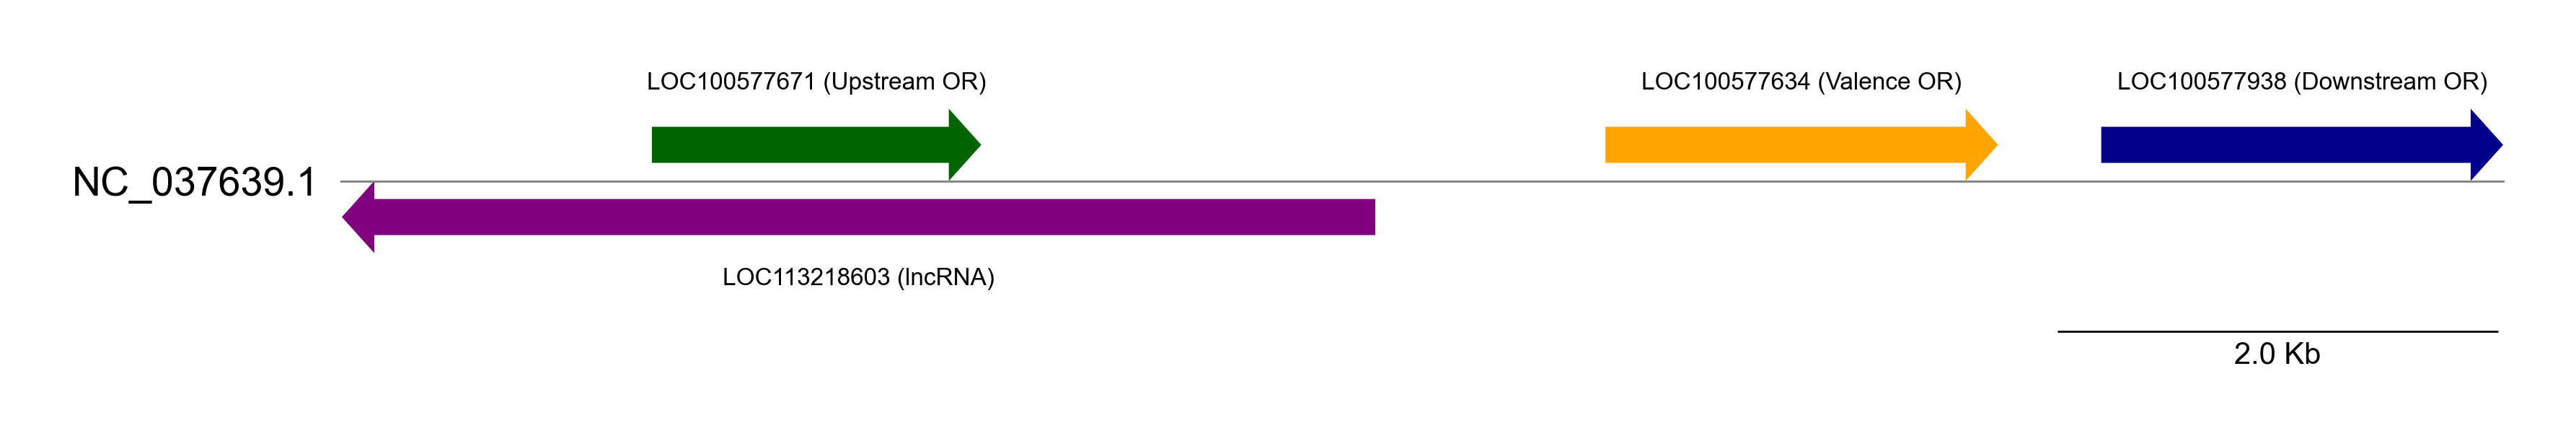

In [87]:
upstream_OR = cells['upstream_OR'].values[0]
downstream_OR = cells['downstream_OR'].values[0]
all_bounds = [tr.get_gene(gene).get_transcript_longest_bounds().get_bounds() for gene in [lncRNA, upstream_OR, valence_OR, downstream_OR]]
chromosome = tr.get_gene(lncRNA).chromosome
start = min([bounds[0] for bounds in all_bounds]) - 5
end = max([bounds[1] for bounds in all_bounds]) + 5
print(f"Chromosome: {chromosome}, Start: {start}, End: {end}")

genes_to_plot = [] 

for gene in list(tr.genes.keys()): 
    gene_obj = tr.get_gene(gene) 
    if gene_obj.chromosome != chromosome: 
        continue
    for transcript in gene_obj.transcripts: 
        if transcript.get_bounds()[0] > start and transcript.get_bounds()[1] < end: 
            genes_to_plot.append(gene)
            break 

white_plotting()
gv = GenomeViz(track_align_type="center", theme="light")
gv.set_scale_bar(ymargin=0.5)

fontsize=12 

# Get bounds 
track = gv.add_feature_track(chromosome, segments = (int(start), int(end)))
#track.add_sublabel(size=fontsize)

# Add gene models to plot 
for gene in genes_to_plot:
    transcript = tr.get_gene(gene).get_transcript_longest_bounds()
    if upstream_OR in gene: 
        color = 'darkgreen'
        label = f'{gene} (Upstream OR)'
    elif downstream_OR in gene:
        color = 'darkblue'
        label = f'{gene} (Downstream OR)'
    elif valence_OR in gene:
        color = 'orange'
        label = f'{gene} (Valence OR)'
    elif lncRNA in gene: 
        color = 'purple'
        label = f'{gene} (lncRNA)'
    else: 
        color = 'grey'
        label = gene
        
    bounds = transcript.get_bounds()
    strand = np.where(transcript.strand == '+', 1, -1) 
    vpos = "top" if strand == 1 else "bottom"
    track.add_feature(
        int(bounds[0]),
        int(bounds[1]), 
        strand, 
        plotstyle='arrow', 
        fc=color, 
        arrow_shaft_ratio = 0.5, 
        label=label, 
        text_kws={'color': 'black', 
                  'rotation': 0, 
                  'vpos': vpos, 
                  'hpos': 'center', 
                  'size':fontsize}
    )

fig = gv.plotfig()
plt.show()

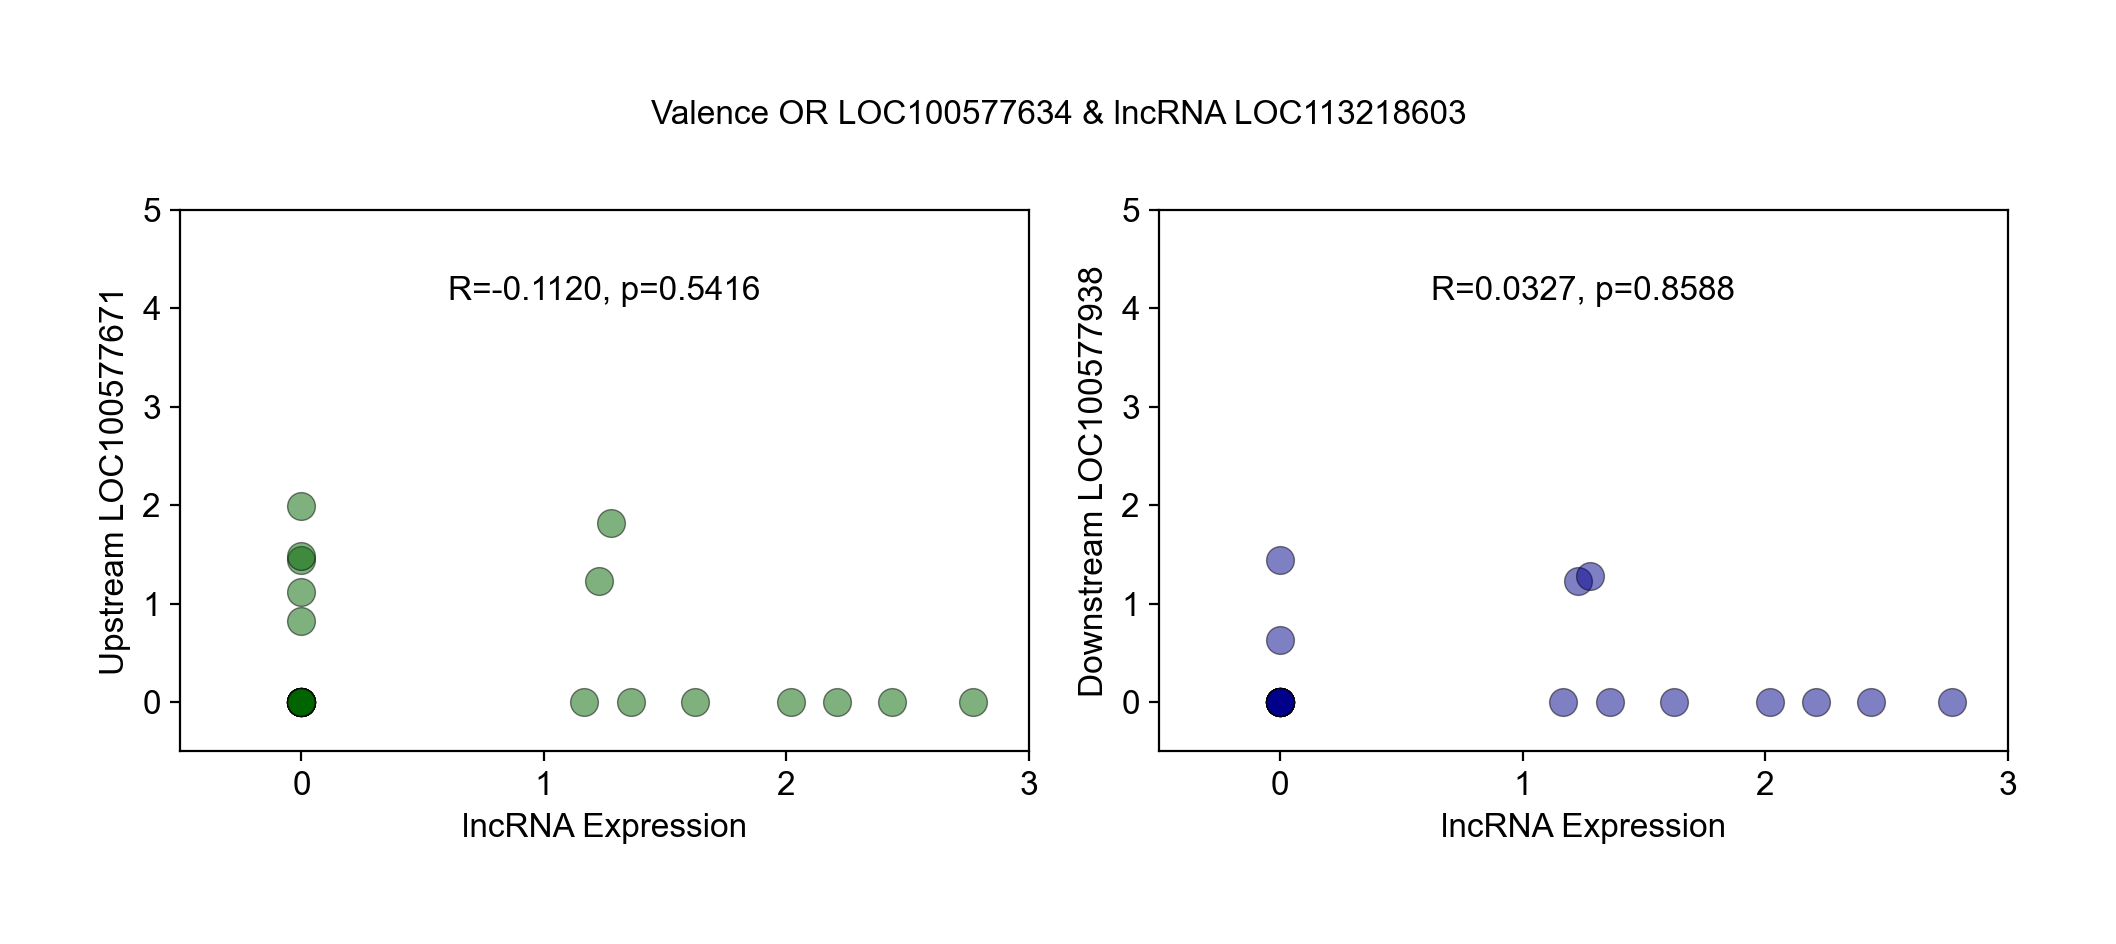

In [88]:
# Plot ustream OR expresion and downstream OR expression vs lncRNA expression bin 
white_plotting()
fontsize=12
f, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
colors = ['darkgreen', 'darkblue']
for i, OR in enumerate(['Upstream', 'Downstream']):
    sns.scatterplot(data=cells, x='lncRNA_expression', y=f'{OR.lower()}_OR_expression', ax=ax[i], color=colors[i], s=100, legend=False, lw=0.5, edgecolor='black', alpha=0.5)
    ax[i].set_xlabel('lncRNA Expression', fontsize=fontsize)
    ax[i].set_ylabel(f'{OR} {cells.iloc[0][OR.lower() + "_OR"]}', fontsize=fontsize)
    r, p = pearsonr(cells['lncRNA_expression'], cells[f'{OR.lower()}_OR_expression'])
    ax[i].text(0.5, 0.85, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[i].transAxes, color='black')
    ax[i].set_ylim(-0.5, 5)
    ax[i].set_yticks([0, 1, 2, 3, 4, 5])
    ax[i].set_yticklabels(['0', '1', '2', '3', '4', '5'], fontsize=fontsize)
    ax[i].set_xlim(-0.5, 3)
    ax[i].set_xticks([0, 1, 2, 3])
    ax[i].set_xticklabels(['0', '1', '2', '3'], fontsize=fontsize)

plt.suptitle(f"Valence OR {valence_OR} & lncRNA {lncRNA}", fontsize=fontsize)
plt.tight_layout()
plt.show()

## lncRNAs with 3' end close to OR TSS 

In [89]:
min(cell_valence_OR['tss_2_lnc_end']), max(cell_valence_OR['tss_2_lnc_end'])

(145.0, 9387.0)

In [90]:
min(cell_valence_OR['lncRNA_expression']), max(cell_valence_OR['lncRNA_expression'])

(0.0, 4.241228103637695)

In [91]:
min(cell_valence_OR['upstream_OR_expression']), max(cell_valence_OR['upstream_OR_expression'])

(0.0, 3.6699862480163574)

In [92]:
min(cell_valence_OR['downstream_OR_expression']), max(cell_valence_OR['downstream_OR_expression'])

(0.0, 3.2230544090270996)

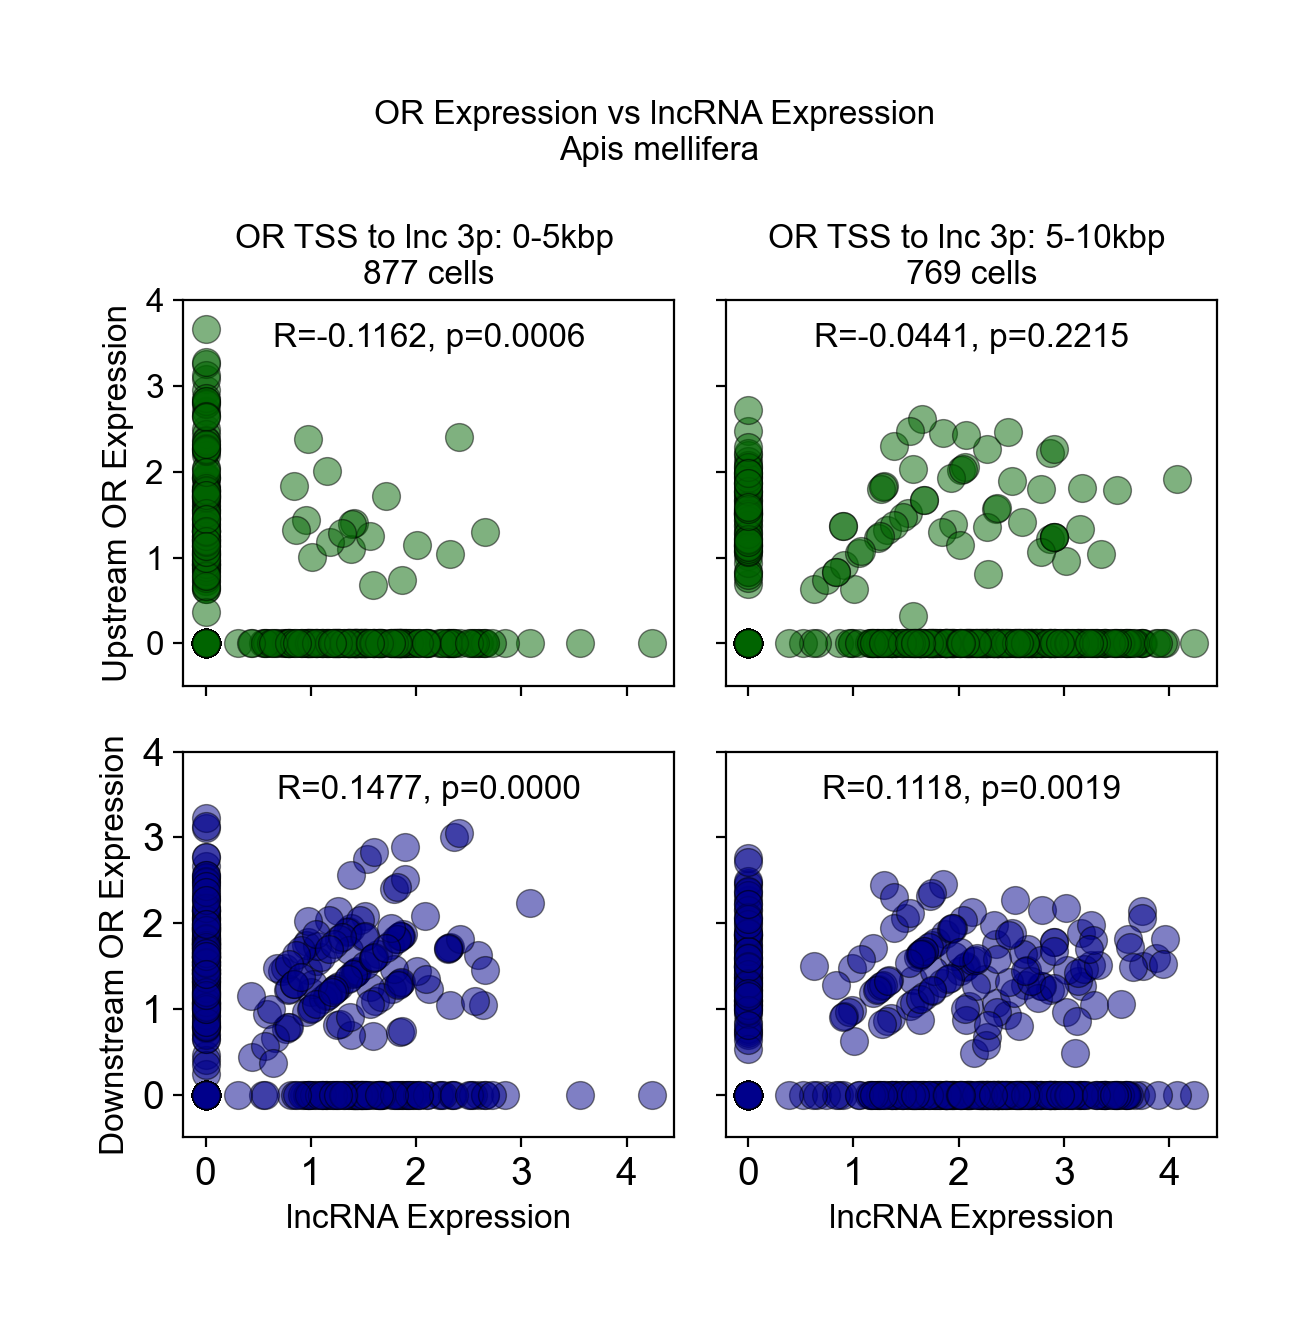

In [93]:
distances = [0, 5000, 10000] 
white_plotting()
fontsize=12
# For each tss_2_lnc_end bin, plot a scatter plot of upstream OR expression vs lncRNA expression
f, ax = plt.subplots(2, len(distances)-1, figsize=(6, 6), sharex=True, sharey=True)
for i in range(len(distances)-1): 
    min_dist = distances[i]
    max_dist = distances[i+1]
    p14_cell_valence_OR_close_bin = cell_valence_OR[(cell_valence_OR['tss_2_lnc_end'] > min_dist) & (cell_valence_OR['tss_2_lnc_end'] < max_dist)]
    
    # Upstream 
    sns.scatterplot(data=p14_cell_valence_OR_close_bin, x='lncRNA_expression', y='upstream_OR_expression', ax=ax[0, i], color='darkgreen', s=100, legend=False, alpha=0.5, lw=0.5, edgecolor='black')
    r, p = pearsonr(p14_cell_valence_OR_close_bin['lncRNA_expression'], p14_cell_valence_OR_close_bin['upstream_OR_expression'])
    ax[0, i].text(0.5, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[0, i].transAxes, color='black')
    ax[0, i].set_ylabel('Upstream OR Expression', fontsize=fontsize)
    ax[0, i].set_title(f'OR TSS to lnc 3p: {int(min_dist/1000)}-{int(max_dist/1000)}kbp \n{p14_cell_valence_OR_close_bin.shape[0]} cells', fontsize=fontsize)
    ax[0, i].set_ylim(-0.5, 4)

    # Downstream 
    sns.scatterplot(data=p14_cell_valence_OR_close_bin, x='lncRNA_expression', y='downstream_OR_expression', ax=ax[1, i], color='darkblue', s=100, legend=False, alpha=0.5, lw=0.5, edgecolor='black')
    r, p = pearsonr(p14_cell_valence_OR_close_bin['lncRNA_expression'], p14_cell_valence_OR_close_bin['downstream_OR_expression'])
    ax[1, i].text(0.5, 0.9, f'R={r:.4f}, p={p:.4f}', fontsize=fontsize, ha='center', va='center', transform=ax[1, i].transAxes, color='black')
    ax[1, i].set_ylabel('Downstream OR Expression', fontsize=fontsize)
    ax[1, i].set_xlabel('lncRNA Expression', fontsize=fontsize)
    ax[0, i].set_yticks([0, 1, 2, 3, 4])
    ax[0, i].set_yticklabels(['0', '1', '2', '3', '4'], fontsize=fontsize)
    # xticks 0 - 6, fontsize
    ax[0, i].set_xticks([0, 1, 2, 3, 4])
    ax[0, i].set_xticklabels(['0', '1', '2', '3', '4'], fontsize=fontsize)

plt.suptitle("OR Expression vs lncRNA Expression \nApis mellifera", fontsize=fontsize)

plt.tight_layout()
plt.show()

In [94]:
# Get unique lncRNAs 
lncRNAs = cell_valence_OR['lncRNA'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for lncRNA in lncRNAs: 
    # Get the valence OR with the smallest tss_2_lnc_end
    closest_valence, tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['lncRNA'] == lncRNA].sort_values('tss_2_lnc_end').iloc[0][['valence_OR', 'tss_2_lnc_end']]
    cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == closest_valence)]
    if cells.shape[0] < 3: 
        # Skip if there are fewer than 3 cells, necessary for Pearson correlation
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])

    results.append({'lncRNA': lncRNA, 'valence': closest_valence, 'n_cells':cells.shape[0], 'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'tss_2_lnc_end': tss_2_lnc_end})

results = pd.DataFrame(results)
results

,lncRNA,valence,n_cells,r_up,p_up,r_down,p_down,tss_2_lnc_end
0,LOC107966099,Or4,166,-0.030546,0.696037,0.088491,0.256905,1971.0
1,LOC113218588,LOC100576914,34,-0.146449,0.408540,0.115382,0.515824,1602.0
2,LOC107966098,LOC102655553,27,NaN,NaN,0.149623,0.456342,1530.0
3,LOC102656092,LOC100577334,35,-0.029412,0.866804,0.355543,0.036076,145.0
4,LOC107966088,Or26,77,0.020127,0.862069,0.051274,0.657869,2146.0
...,...,...,...,...,...,...,...,...
6,LOC107966089,Or51,30,-0.035974,0.850306,0.052709,0.782067,3087.0
7,LOC107965274,LOC102655180,121,-0.290205,0.001243,0.312974,0.000474,1120.0
8,LOC113218603,LOC100577671,92,-0.222831,0.032759,0.139503,0.184750,1407.0
9,LOC102656676,LOC100576816,32,-0.170807,0.349952,0.079526,0.665267,2658.0


In [95]:
# LOC107966098 lncRNA in cell_valence_OR
cell_valence_OR[cell_valence_OR['lncRNA'] == 'LOC107966098']

,cell_index,valence_OR,valence_OR_tr,tandem_array,or_strand,lncRNA,tss_2_lnc_end,tss2tss,lnc_strand,lncRNA_expression,valence_OR_expression,upstream_OR,downstream_OR,upstream_OR_strand,downstream_OR_strand,upstream_OR_expression,downstream_OR_expression
2,AAACCGGCAGCAAGGC-1-0,Or9,Or9,12,+,LOC107966098,5577.0,-3654.0,-,0.520226,0.520226,LOC102655553,Or10,+,+,0.0,0.000000
33,AATGCAACAAGGTCGA-1-0,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,0.000000,0.853904,Or9,Or11,+,+,0.0,0.000000
36,AATTAGGCACCAACCG-1-0,LOC102655553,LOC102655553,12,+,LOC107966098,1530.0,-7701.0,-,0.000000,2.557047,LOC102655434,Or9,+,+,0.0,0.000000
37,AATTGGACACGAACAG-1-0,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,1.232909,0.679291,Or9,Or11,+,+,0.0,0.000000
51,ACCAGCTCACCAGCAT-1-0,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,0.000000,1.731096,Or9,Or11,+,+,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,TGCTTCCAGCCTAATA-1-2,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,2.965609,1.834021,Or9,Or11,+,+,0.0,0.000000
1610,TGTAAAGCATTGTGGC-1-2,Or9,Or9,12,+,LOC107966098,5577.0,-3654.0,-,3.278266,2.622120,LOC102655553,Or10,+,+,0.0,1.809263
1633,TTGTTCCCAACACCTA-1-2,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,3.236924,2.037268,Or9,Or11,+,+,0.0,1.694959
1641,TTTGGCTGTAAAGCAA-1-2,Or10,Or10,12,+,LOC107966098,9387.0,156.0,-,0.000000,1.166710,Or9,Or11,+,+,0.0,0.000000


In [96]:
# drop nan rows 
results = results.dropna().reset_index(drop=True)

## Plot correlations for each unique lncRNA

In [97]:
# Get unique lncRNAs 
lncRNAs = cell_valence_OR['lncRNA'].unique()

# For each lncRNA, get the Pearson correlation of lncRNA expression vs OR expression for upstream and downstream ORs
results = [] 
for lncRNA in lncRNAs: 
    # Get the valence OR with the smallest tss_2_lnc_end
    closest_valence, tss_2_lnc_end = cell_valence_OR.loc[cell_valence_OR['lncRNA'] == lncRNA].sort_values('tss_2_lnc_end').iloc[0][['valence_OR', 'tss_2_lnc_end']]
    cells = cell_valence_OR[(cell_valence_OR['lncRNA'] == lncRNA) & (cell_valence_OR['valence_OR'] == closest_valence)]
    if cells.shape[0] < 3: 
        # Skip if there are fewer than 3 cells, necessary for Pearson correlation
        continue
    r_up, p_up = pearsonr(cells['lncRNA_expression'], cells[f'upstream_OR_expression'])
    r_down, p_down = pearsonr(cells['lncRNA_expression'], cells[f'downstream_OR_expression'])
    r_valence, p_up = pearsonr(cells['lncRNA_expression'], cells['valence_OR_expression'])

    tss_2_lnc_end = cells['tss_2_lnc_end'].values[0]
    tss2tss = cells['tss2tss'].values[0]

    results.append({'lncRNA':lncRNA, 'valence': closest_valence, 'n_cells':cells.shape[0],  'tss_2_lnc_end': tss_2_lnc_end, 'tss2tss': tss2tss, 
                    'r_up': r_up, 'p_up': p_up, 'r_down': r_down, 'p_down': p_down, 'r_valence': r_valence, 'p_valence': p_up})

results = pd.DataFrame(results)
results

,lncRNA,valence,n_cells,tss_2_lnc_end,tss2tss,r_up,p_up,r_down,p_down,r_valence,p_valence
0,LOC107966099,Or4,166,1971.0,-8221.0,-0.030546,0.024036,0.088491,0.256905,0.175110,0.024036
1,LOC113218588,LOC100576914,34,1602.0,-889.0,-0.146449,0.312635,0.115382,0.515824,0.178443,0.312635
2,LOC107966098,LOC102655553,27,1530.0,-7701.0,NaN,0.924698,0.149623,0.456342,-0.019092,0.924698
3,LOC102656092,LOC100577334,35,145.0,-2667.0,-0.029412,0.300026,0.355543,0.036076,0.180287,0.300026
4,LOC107966088,Or26,77,2146.0,-10060.0,0.020127,0.567772,0.051274,0.657869,-0.066120,0.567772
...,...,...,...,...,...,...,...,...,...,...,...
6,LOC107966089,Or51,30,3087.0,-1848.0,-0.035974,0.160152,0.052709,0.782067,0.263072,0.160152
7,LOC107965274,LOC102655180,121,1120.0,-3783.0,-0.290205,0.007517,0.312974,0.000474,0.241892,0.007517
8,LOC113218603,LOC100577671,92,1407.0,-3283.0,-0.222831,0.415364,0.139503,0.184750,-0.085934,0.415364
9,LOC102656676,LOC100576816,32,2658.0,-919.0,-0.170807,0.251831,0.079526,0.665267,0.208633,0.251831


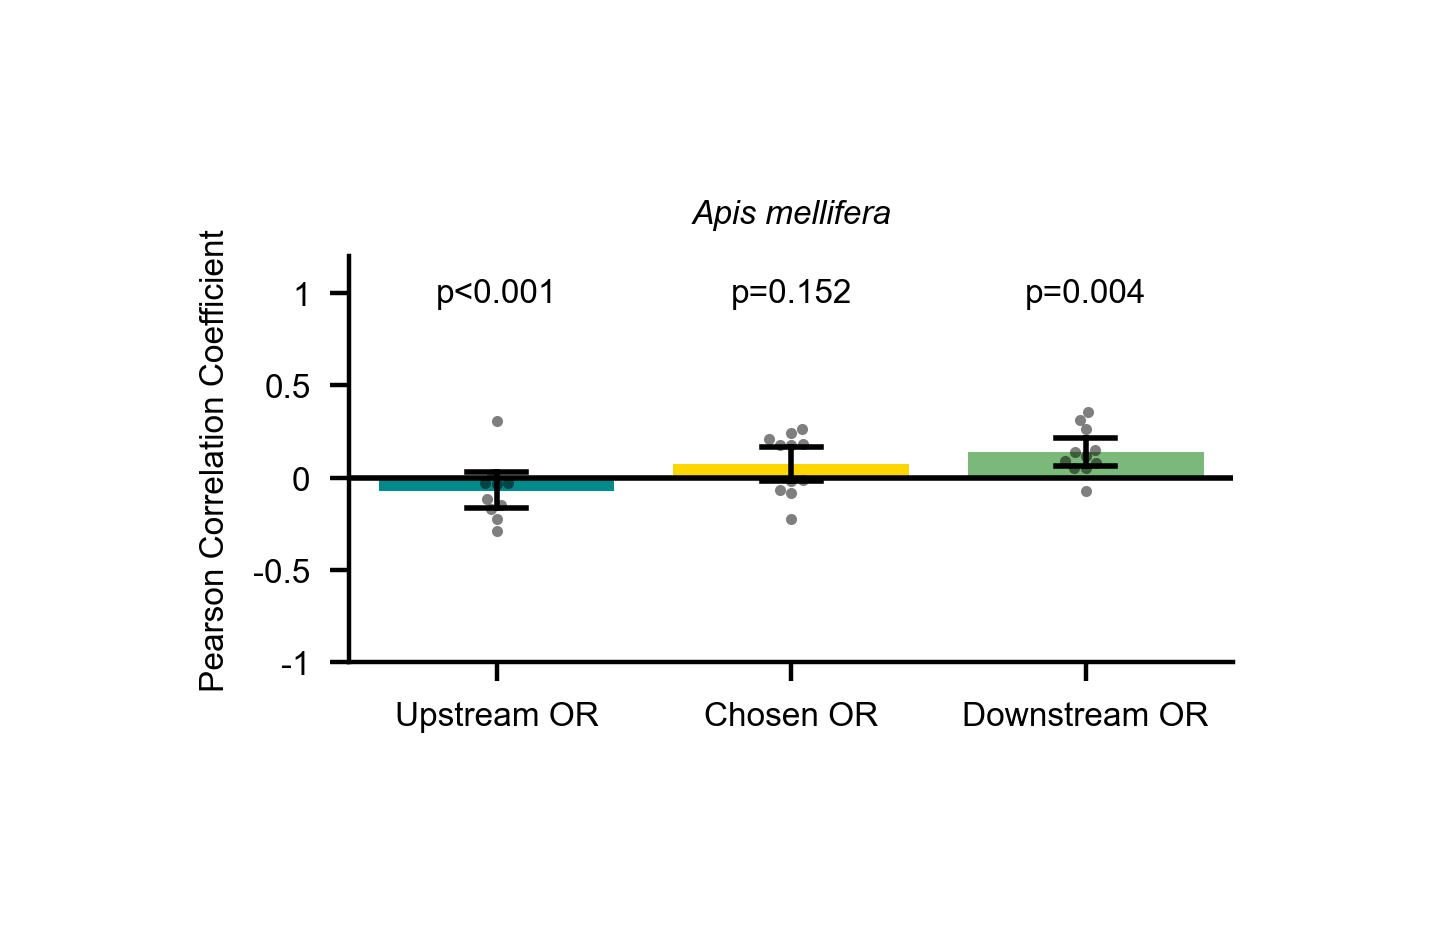

In [98]:
# Plot bar plot of unique lncRNAs with closest valence OR, r_up, r_valence, r_down
max_distance = 5_000 
results_subset = results[(results['tss_2_lnc_end'] < max_distance) & (results['tss_2_lnc_end'] > 0)]
white_plotting()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
f, ax = plt.subplots(1, 1, figsize=(3, 1.75), dpi=200)

sns.barplot(data=results_subset, x=0, y='r_up', ax=ax, color='darkcyan', alpha=1, label='Upstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=1, y='r_valence', ax=ax, color='gold', alpha=1, label='Valence', saturation=1, errcolor='black', capsize=0.2, errwidth=1)
sns.barplot(data=results_subset, x=2, y='r_down', ax=ax, color='forestgreen', alpha=0.6, label='Downstream', saturation=1, errcolor='black', capsize=0.2, errwidth=1)

sns.swarmplot(data=results_subset, x=0, y='r_up', ax=ax, color='black', size=2, alpha=0.5)
sns.swarmplot(data=results_subset, x=1, y='r_valence', ax=ax, color='black', size=2, alpha=0.5)
sns.swarmplot(data=results_subset, x=2, y='r_down', ax=ax, color='black', size=2, alpha=0.5)

ax.set_xticks([0, 1, 2], ['Upstream OR', 'Chosen OR', 'Downstream OR'], fontsize=6)
ax.set_ylabel('Pearson Correlation Coefficient', fontsize=6)
ax.set_title('Apis mellifera', fontsize=6, style='italic')
plt.legend([],[], frameon=False)
ax.set_ylim(-1, 1.2)
ax.set_yticks([-1, -0.5, 0, 0.5, 1], labels=['-1', '-0.5', '0', '0.5', '1'], fontsize=6)
# line at y=0
plt.axhline(0, color='black', lw=1)

# remove spines 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# Add stats (different from 0) 
from scipy.stats import ttest_1samp
for i, or_ in enumerate(['up', 'valence', 'down']):
    r = results_subset[f'r_{or_}']
    t, p = ttest_1samp(r, 0)
    p_value_str = f"p={p:.3f}" if p >= 0.001 else "p<0.001"
    plt.text(i, 1, p_value_str, ha='center', va='center', transform=ax.transData, fontsize=6, color='black')

plt.tight_layout()
plt.savefig(f"../figures/Amell-lnc-inhibits-correlations.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()